In [0]:
!pip3 -qq install torch==0.4.1
!pip -qq install torchtext==0.3.1

In [0]:
!wget -qq --no-check-certificate 'https://drive.google.com/uc?export=download&id=1Pq4aklVdj-sOnQw68e1ZZ_ImMiC8IR1V' -O tweets.csv.zip
!wget -qq --no-check-certificate "https://drive.google.com/uc?export=download&id=1ji7dhr9FojPeV51dDlKRERIqr3vdZfhu" -O surnames.txt
!unzip tweets.csv.zip

In [0]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


if torch.cuda.is_available():
    from torch.cuda import FloatTensor, LongTensor
    DEVICE = torch.device('cuda')
else:
    from torch import FloatTensor, LongTensor
    DEVICE = torch.device('cpu')

np.random.seed(42)

# Языковые модели

*Языковая модель* - это штука, которая умеет оценивать вероятности встретить последовательность слов $w_1, \ldots, w_n$:   
$$\mathbf{P}(w_1, \ldots, w_n) = \prod_k \mathbf{P}(w_k|w_{k-1}, \ldots, w_{1}).$$

Интерпретируемы и интересны тут именно условные вероятности - какое слово языковая модель ожидает вслед за данными. У нас у всех такая языковая модель есть, так-то. Например, в таком контексте

![](https://hsto.org/web/956/239/601/95623960157b4e15a1b3f599aed62ed2.png =x170)

моя языковая модель говорит - после *честных* навряд ли пойдёт *мой*. А вот *и* или, конечно, *правил* - очень даже.

А задача такая: научиться генерировать политические твиты по образу и подобию `Russian Troll Tweets`. Датасет взят отсюда: https://www.kaggle.com/vikasg/russian-troll-tweets

In [5]:
data = pd.read_csv('tweets.csv')

data.text.sample(15).tolist()

['RT @RivalThoughts: @CNN This lack of forethought is what ran the country into the ground.',
 "#TopNews Icahn on CNBC:'Archie Bunker of the world' will vote for Trump",
 'RT @mclark1951: Just 5.7 Percent Of #Clinton Foundation Budget Actually Went To Charitable Grants https://t.co/c2EIYW4w9H #uniteblue2016 #p…',
 "RT @JamilSmith: Read @jelani9 on Rudy Giuliani's flailing effort to gain relevance in this Trump moment. https://t.co/48p9d31pgi",
 'RT @Laura_A_Diaz: #StandUpWithEvan #MakeHistoryWithEvan  Unite and #Vote3rdParty #Deny270 https://t.co/quB1FdZZAo',
 'RT @MommyExchangeGa: Camouflage Wedding Rings Made From Titanium! High Quality. Choose from Promise, Wedding, Friendship and Couples https:…',
 'RT @NewssTrump: BREAKING: Trump’s UN Ambassador Just Put The Fear Of God In Our Enemies! She Just Gave The UN Teeth For The First… https://…',
 '@Nero March for Trump at Trump tower NY happening now:\n#Trump #MAGA https://t.co/SWvbWxOEjO',
 "Why don't Portuguese Muslims speak out and co

Да, результаты будут упороты, сразу предупреждаю.

## Чтение данных

Кого-нибудь уже достало писать все эти построения батчей, словари - вот это всё? Лично меня - да!

В pytorch есть специальный класс для генерации батчей - `Dataset`. Вместо того, чтобы писать функцию типа `iterate_batches`, можно отнаследовать от него и переопределить методы `__len__` и `__getitem__`... и реализовать в них почти всё то, что было в `iterate_batches`. Пока не впечатляет, да?

Ещё там есть `DataLoader`, умеющий работать с датасетом. Он позволяет делать shuffle батчей и генерацию их в отдельных процессах - это особенно важно, когда генерация батча - долгая операция. Например, в картинках. Почитать про это всё можно здесь: [Data Loading and Processing Tutorial](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html).

Но пока что всё равно не особо круто, мне кажется. Интересно другое - у pytorch в репозитории живет отдельная библиотечка - [torchtext](https://github.com/pytorch/text). Вот она уже даст нам специальные реализации `Dataset` для работы с текстом и всякие тулзы, делающие жизнь чуточку проще.

Библиотеке, на мой взгляд, недостает туториалов, в которых бы показывалось, как с ней работать - но можно читать исходный код, он приятный.

План такой: построить класс `torchtext.data.Dataset`, для него создать итератор, и учить модель.

Данный датасет инициализируется двумя параметрами:
```
            examples: List of Examples.
            fields (List(tuple(str, Field))): The Fields to use in this tuple. The
                string is a field name, and the Field is the associated field.
```
Разберемся сначала со вторым.

`Field` - это такая мета-информация для датасета + обработчик сэмплов.  

Он имеет кучу параметров, на которые проще посмотреть [здесь](https://github.com/pytorch/text/blob/master/torchtext/data/field.py). Если коротко, то он может предобрабатывать (например, токенизировать) предложения, строить словарь (отображение из слова в индекс), строить батчи - добавлять паддинги и конвертировать в тензоры. Что ещё нужно в жизни?

Мы будем делать character-level языковую модель, поэтому токенизация для нас - превращение строки в набор символов. Попросим также добавлять в начало и конец спец-символы `<s>` и `</s>`.

In [0]:
from torchtext.data import Field

text_field = Field(init_token='<s>', eos_token='</s>', lower=True, tokenize=lambda line: list(line))

Препроцессинг будет выглядеть так:

In [7]:
text_field.preprocess(data.text.iloc[0])

['#',
 'i',
 's',
 'l',
 'a',
 'm',
 'k',
 'i',
 'l',
 'l',
 's',
 ' ',
 'a',
 'r',
 'e',
 ' ',
 'y',
 'o',
 'u',
 ' ',
 't',
 'r',
 'y',
 'i',
 'n',
 'g',
 ' ',
 't',
 'o',
 ' ',
 's',
 'a',
 'y',
 ' ',
 't',
 'h',
 'a',
 't',
 ' ',
 't',
 'h',
 'e',
 'r',
 'e',
 ' ',
 'w',
 'e',
 'r',
 'e',
 ' ',
 'n',
 'o',
 ' ',
 't',
 'e',
 'r',
 'r',
 'o',
 'r',
 'i',
 's',
 't',
 ' ',
 'a',
 't',
 't',
 'a',
 'c',
 'k',
 's',
 ' ',
 'i',
 'n',
 ' ',
 'e',
 'u',
 'r',
 'o',
 'p',
 'e',
 ' ',
 'b',
 'e',
 'f',
 'o',
 'r',
 'e',
 ' ',
 'r',
 'e',
 'f',
 'u',
 'g',
 'e',
 'e',
 's',
 ' ',
 'w',
 'e',
 'r',
 'e',
 ' ',
 'l',
 'e',
 't',
 ' ',
 'i',
 'n',
 '?']

Сконвертируем всё и посмотрим на распределение длин:

<a list of 30 Patch objects>

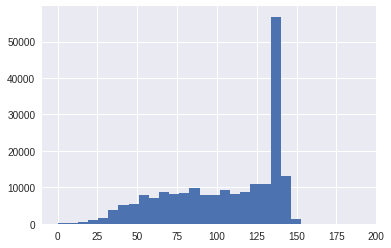

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

data['text'] = data['text'].fillna('')
lines = data.apply(lambda row: text_field.preprocess(row['text']), axis=1).tolist()

lengths = [len(line) for line in lines]

plt.hist(lengths, bins=30)[-1]

Отсечем слишком короткие строки и преобразуем оставшиеся в `Example`'ы:

In [0]:
from torchtext.data import Example

lines = [line for line in lines if len(line) >= 50]

fields = [('text', text_field)]
examples = [Example.fromlist([line], fields) for line in lines]

По `Example` можно получить обратно все поля, которые мы туда запихнули. Например, сейчас мы создали одно поле `text`:

In [10]:
examples[0].text

['#',
 'i',
 's',
 'l',
 'a',
 'm',
 'k',
 'i',
 'l',
 'l',
 's',
 ' ',
 'a',
 'r',
 'e',
 ' ',
 'y',
 'o',
 'u',
 ' ',
 't',
 'r',
 'y',
 'i',
 'n',
 'g',
 ' ',
 't',
 'o',
 ' ',
 's',
 'a',
 'y',
 ' ',
 't',
 'h',
 'a',
 't',
 ' ',
 't',
 'h',
 'e',
 'r',
 'e',
 ' ',
 'w',
 'e',
 'r',
 'e',
 ' ',
 'n',
 'o',
 ' ',
 't',
 'e',
 'r',
 'r',
 'o',
 'r',
 'i',
 's',
 't',
 ' ',
 'a',
 't',
 't',
 'a',
 'c',
 'k',
 's',
 ' ',
 'i',
 'n',
 ' ',
 'e',
 'u',
 'r',
 'o',
 'p',
 'e',
 ' ',
 'b',
 'e',
 'f',
 'o',
 'r',
 'e',
 ' ',
 'r',
 'e',
 'f',
 'u',
 'g',
 'e',
 'e',
 's',
 ' ',
 'w',
 'e',
 'r',
 'e',
 ' ',
 'l',
 'e',
 't',
 ' ',
 'i',
 'n',
 '?']

Построим, наконец, датасет:

In [0]:
from torchtext.data import Dataset

dataset = Dataset(examples, fields)

Датасет можно разбить на части:

In [0]:
train_dataset, test_dataset = dataset.split(split_ratio=0.75)

По нему можно построить словарь:

In [13]:
text_field.build_vocab(train_dataset, min_freq=30)

print('Vocab size =', len(text_field.vocab))
print(text_field.vocab.itos)

Vocab size = 316
['<unk>', '<pad>', '<s>', '</s>', ' ', 't', 'e', 'a', 'o', 'r', 'i', 's', 'n', 'l', 'h', 'c', 'p', 'd', 'm', 'u', '/', 'g', 'y', ':', 'w', 'b', 'f', '.', '@', 'k', 'v', '#', 'j', 'z', 'x', '\n', "'", '…', '1', ',', '0', '2', 'q', '\r', '!', '4', '6', '7', '3', '"', '5', '-', '9', '8', '_', '?', ';', '’', '&', ')', '(', '‘', '“', '😂', '$', '|', '”', '*', '%', '–', '️', '🇸', '🇺', 'о', 'а', '\xa0', 'ü', 'и', 'е', '▶', 'т', '~', 'н', '+', '🔥', 'р', 'ä', '💥', '[', '—', ']', 'л', '=', 'с', '🚨', 'в', 'é', 'к', '❤', 'м', 'п', '👇', 'д', 'ö', '👍', '🤔', '👏', '‼', 'ا', 'у', '★', '🏾', '🏻', '`', '👉', '🙏', '�', 'б', '😡', '😭', '🏼', 'з', 'ы', '😊', 'ь', 'г', '😍', 'ß', 'ل', '🏽', 'я', '🏿', '💯', '🙄', '»', 'й', '💀', '•', 'ч', '✊', '✔', '😳', 'ي', '➡', '😎', 'à', 'ा', '🙌', 'ر', 'م', '💩', '✨', 'و', '⚡', '👊', '🎉', 'ن', 'ж', '💪', '😉', 'х', '😘', '«', '🌟', 'è', '😏', 'े', 'ш', '💰', '💨', 'क', 'ю', 'र', 'ت', '►', 'ب', '🚂', '➠', '😱', '\u200b', '😩', '😁', 'د', '✅', '❗', '👀', '´', 'ه', '👌', 'י', '🎄', '☺',

Наконец, по нему можно итерироваться:

In [0]:
from torchtext.data import BucketIterator

train_iter, test_iter = BucketIterator.splits(datasets=(train_dataset, test_dataset), batch_sizes=(32, 128), 
                                              shuffle=True, device=DEVICE, sort=False)

In [15]:
batch = next(iter(train_iter))

batch


[torchtext.data.batch.Batch of size 32]
	[.text]:[torch.cuda.LongTensor of size 146x32 (GPU 0)]

In [16]:
batch.text

tensor([[ 2,  2,  2,  ...,  2,  2,  2],
        [19, 21,  9,  ...,  9,  9,  9],
        [12, 19,  5,  ...,  5,  5,  5],
        ...,
        [ 1,  1,  1,  ..., 19,  1,  1],
        [ 1,  1,  1,  ..., 37,  1,  1],
        [ 1,  1,  1,  ...,  3,  1,  1]], device='cuda:0')

## Перплексия

Нашу задачу, как всегда, нужно начинать с двух вопросов - какую метрику оптимизируем и какой бейзлайн.

С метрикой всё просто - мы хотим, чтобы модель как можно лучше умела приближать распределение слов языка. Всего языка у нас нету, поэтому обойдёмся тестовой выборкой.

На ней можно посчитать кросс-энтропийные потери: 
$$H(w_1, \ldots, w_n) = - \frac 1n \sum_k \log\mathbf{P}(w_k | w_{k-1}, \ldots, w_1).$$

Здесь вероятность $\mathbf{P}$ - это вероятность, оцененная нашей языковой моделью. Идеальная модель давала бы вероятность равную 1 для слов в тексте и потери были бы нулевыми - хотя это, конечно, невозможно, даже вы же не можете предсказать следующее слово, что уж про бездушную машину говорить.

Таким образом, всё как всегда - оптимизируем кросс-энтропию и стремимся сделать её как можно ниже.

Ну, почти всё. Ещё есть отдельная метрика для языковых моделей - *перплексия*. Это просто возведенные в экспоненту кросс-энтропийные потери:

$$PP(w_1, \ldots, w_n) = e^{H(w_1, \ldots, w_n)} = e^{- \frac 1n \sum_k \log\mathbf{P}(w_k | w_{k-1}, \ldots, w_1)} = \left(\mathbf{P}(w_1, \ldots, w_n) \right)^{-\frac 1n}.$$

У её измерения есть некоторый сакральный смысл кроме банальной интепретируемости: представим модель, предсказывающую слова из словаря равновероятно вне зависимости от контекста. Для неё $\mathbf{P}(w) = \frac 1 N$, где $N$ — размер словаря, а перплексия будет равна размеру словаря — $N$. Конечно, это совершенно глупая модель, но оглядываясь на неё, можно трактовать перплексию реальных моделей как уровень неоднозначности генерации слова.

Скажем, в модели с перплексией 100 выбор следующего слова также неоднозначен, как выбор из равномерного распределения среди 100 слов. И если такой перплексии удалось достичь на словаре в 100 000, получается, что удалось сократить эту неоднозначность на три порядка по сравнению с тупым рандомом.

## Бейзлайн

Вообще, бейзлайн тут тоже очень простой. Мы, на самом деле, даже смотрели его на курсе концепций: [N-граммная языковая модель](https://colab.research.google.com/drive/1lz9vO6Ue5zOiowEx0-koXNiejBrrnbj0). Можно подсчитывать вероятности N-грамм слов по частотностям их появления в обучающем корпусе. А дальше использовать аппроксимацию $\mathbf{P}(w_k|w_1, \ldots, w_{k-1}) \approx \mathbf{P}(w_k|w_{k-1}, \ldots, w_{k-N + 1})$.

Применим лучше сеточки для реализации того же.

![](https://image.ibb.co/buMnLf/2018-10-22-00-22-56.png =x450)  
*From cs224n, Lecture 8 [pdf](http://web.stanford.edu/class/cs224n/lectures/lecture8.pdf)*

На вход приходит последовательность слов, они эмбеддятся, а дальше с помощью выходного слоя считается наиболее вероятное следующее слово.

Стоп... Но мы же уже реализовывали такое! В Word2vec CBoW модели мы по контексту предсказывали центральное слово - единственное отличие в том, что теперь мы имеем только левый контекст. Значит, всё, идём к следующей модели?

Нет! Тут ещё есть с чем развлечься. В Word2vec мы формировали батчи таким образом:
![](https://image.ibb.co/bs3wgV/training-data.png =x350)  
*From [Word2Vec Tutorial - The Skip-Gram Model, Chris McCormic](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/)*

То есть нарезали из текста набор пар <контекст, слово> (и как-то их использовали в зависимости от метода).

Это нерационально - каждое слово повторяется много раз. Но можно использовать сверточные сети - они за нас применят операцию умножения на $W$ к каждому окну. В результате размер входного батча будет сильно меньше.

Чтобы правильно всё обработать, нужно добавить паддинг в начало последовательности размером `window_size - 1` - тогда первое слово будет предсказываться по `<pad>...<pad><s>`.

**Задание** Реализуйте языковую модель с фиксированным окном.

In [0]:
class ConvLM(nn.Module):
    def __init__(self, vocab_size, window_size=5, emb_dim=16, filters_count=128):
        super().__init__()
        
        self._window_size = window_size
        
        self._embs = nn.Embedding(vocab_size, emb_dim, padding_idx=1)
        self._conv = nn.Sequential(
            nn.Conv1d(emb_dim, filters_count, kernel_size=self._window_size),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(filters_count)
        )
        self._output = nn.Linear(filters_count, vocab_size)
        
    def forward(self, inputs):
        # Left-side paddings
        padding = inputs.new_zeros((self._window_size - 1, inputs.shape[1]))
        
        # Cat for correct convolutions
        inputs = torch.cat((padding, inputs), 0)
        
        # Embeddings
        embs = self._embs(inputs)
        
        # Permute for further convolutions
        embs = embs.permute((1, 2, 0))
        
        # Convolutions
        output = self._conv(embs)
        
        # Permute for output layer
        output = output.permute((2, 0, 1))
        
        return self._output(output), None  # hacky way to use training cycle for RNN and Conv simultaneously

Проверим, что оно работает:

In [16]:
model = ConvLM(vocab_size=len(train_iter.dataset.fields['text'].vocab)).to(DEVICE)

model(batch.text)

(tensor([[[ 0.4009, -0.0297,  0.1841,  ...,  0.3713, -0.1979, -0.0953],
          [ 0.4009, -0.0297,  0.1841,  ...,  0.3713, -0.1979, -0.0953],
          [ 0.4009, -0.0297,  0.1841,  ...,  0.3713, -0.1979, -0.0953],
          ...,
          [ 0.4009, -0.0297,  0.1841,  ...,  0.3713, -0.1979, -0.0953],
          [ 0.4009, -0.0297,  0.1841,  ...,  0.3713, -0.1979, -0.0953],
          [ 0.4009, -0.0297,  0.1841,  ...,  0.3713, -0.1979, -0.0953]],
 
         [[ 0.4438, -0.4666, -0.2570,  ...,  0.1318, -0.1998, -0.3067],
          [ 0.2618, -0.2226, -0.4435,  ...,  0.4850,  0.2396, -0.0753],
          [ 0.2618, -0.2226, -0.4435,  ...,  0.4850,  0.2396, -0.0753],
          ...,
          [ 0.4050, -1.0204, -0.2090,  ...,  0.1172, -0.5161,  0.0537],
          [ 0.1138, -0.8134, -0.4508,  ..., -0.0105, -0.1257, -0.1219],
          [ 0.2618, -0.2226, -0.4435,  ...,  0.4850,  0.2396, -0.0753]],
 
         [[ 0.1910, -0.3108,  0.4759,  ..., -0.2926, -0.3941,  0.2617],
          [-0.4090,  0.0923,

**Задание** Реализуйте функцию для сэмплирования последовательности из языковой модели.

In [17]:
def sample(probs, temp):
    probs = F.log_softmax(probs.squeeze(), dim=0)
    probs = (probs / temp).exp()
    probs /= probs.sum()
    probs = probs.cpu().numpy()

    return np.random.choice(np.arange(len(probs)), p=probs)


def generate(model, temp=0.7):
    model.eval()
    
    history = [train_dataset.fields['text'].vocab.stoi['<s>']]
    
    with torch.no_grad():
        for _ in range(150):
            inputs = LongTensor(history).unsqueeze(1)
            
            preds, _ = model(inputs)
            # Need to take the last prediction
            preds = preds[-1]
            
            idx = sample(preds, temp)
            history.append(idx)
            print(train_dataset.fields['text'].vocab.itos[idx], end='')

generate(model)

**Задание** Мы до сих пор не задали ни какой target. А предсказывать нам будет нужно следующие слова - то есть просто сдвинутый на 1 входной тензор. Реализуйте построение target'а и подсчет потерь.

In [18]:
batch.text

tensor([[ 2,  2,  2,  ...,  2,  2,  2],
        [31,  9,  9,  ..., 10, 13,  9],
        [10,  5,  5,  ...,  4,  7,  5],
        ...,
        [ 1,  1,  1,  ...,  1,  1,  1],
        [ 1,  1,  1,  ...,  1,  1,  1],
        [ 1,  1,  1,  ...,  1,  1,  1]], device='cuda:0')

In [19]:
torch.cat((batch.text[1:], batch.text.new_ones((1, batch.text.shape[1]))))

tensor([[31,  9,  9,  ..., 10, 13,  9],
        [10,  5,  5,  ...,  4,  7,  5],
        [14,  4,  4,  ..., 24, 11,  4],
        ...,
        [ 1,  1,  1,  ...,  1,  1,  1],
        [ 1,  1,  1,  ...,  1,  1,  1],
        [ 1,  1,  1,  ...,  1,  1,  1]], device='cuda:0')

In [0]:
import math
from tqdm import tqdm


def do_epoch(model, criterion, data_iter, unk_idx, pad_idx, optimizer=None, name=None):
    epoch_loss = 0
    
    is_train = not optimizer is None
    name = name or ''
    model.train(is_train)
    
    batches_count = len(data_iter)
    
    with torch.autograd.set_grad_enabled(is_train):
        with tqdm(total=batches_count) as progress_bar:
            for i, batch in enumerate(data_iter):                
                logits, _ = model(batch.text)
                
                targets = torch.cat((batch.text[1:], batch.text.new_ones((1, batch.text.shape[1]))))

                loss = criterion(logits.view(-1, logits.shape[-1]), targets.view(-1))
                
                epoch_loss += loss.item()

                if optimizer:
                    optimizer.zero_grad()
                    loss.backward()
                    nn.utils.clip_grad_norm_(model.parameters(), 1.)
                    optimizer.step()

                progress_bar.update()
                progress_bar.set_description('{:>5s} Loss = {:.5f}, PPX = {:.2f}'.format(name, loss.item(), 
                                                                                         math.exp(loss.item())))
                
            progress_bar.set_description('{:>5s} Loss = {:.5f}, PPX = {:.2f}'.format(
                name, epoch_loss / batches_count, math.exp(epoch_loss / batches_count))
            )

    return epoch_loss / batches_count


def fit(model, criterion, optimizer, train_iter, epochs_count=1, unk_idx=0, pad_idx=1, val_iter=None):
    for epoch in range(epochs_count):
        name_prefix = '[{} / {}] '.format(epoch + 1, epochs_count)
        train_loss = do_epoch(model, criterion, train_iter, unk_idx, pad_idx, optimizer, name_prefix + 'Train:')
        
        if not val_iter is None:
            val_loss = do_epoch(model, criterion, val_iter, unk_idx, pad_idx, None, name_prefix + '  Val:')

        generate(model)

In [22]:
model = ConvLM(vocab_size=len(train_iter.dataset.fields['text'].vocab)).to(DEVICE)

pad_idx = train_iter.dataset.fields['text'].vocab.stoi['<pad>']
unk_idx = train_iter.dataset.fields['text'].vocab.stoi['<unk>']
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx).to(DEVICE)

optimizer = optim.Adam(model.parameters())

fit(model, criterion, optimizer, train_iter, epochs_count=30, unk_idx=unk_idx, pad_idx=pad_idx, val_iter=test_iter)

[1 / 30]   Val: Loss = 2.07257, PPX = 7.95: 100%|██████████| 366/366 [00:07<00:00, 49.29it/s]


rt @_taxlj5hd</s>ke who wants deman1: @worldens weal @naystant to protest a don't sim the 

  0%|          | 0/4381 [00:00<?, ?it/s]

preelfor @chnotarder his gover in bmbicking the stark the plays

[2 / 30]   Val: Loss = 2.03907, PPX = 7.68: 100%|██████████| 366/366 [00:07<00:00, 47.89it/s]


rt @shead in a dictive ust mrow maddetter: don'th the pers shote, corming billing us will 

  0%|          | 0/4381 [00:00<?, ?it/s]

in a creat to the laces vote with just is is colled what in 

[3 / 30]   Val: Loss = 2.02560, PPX = 7.58: 100%|██████████| 366/366 [00:07<00:00, 47.96it/s]


rt @thrml beconservatign support chomisy rans https://t.co/bofydpiking of un for trump decal

  0%|          | 0/4381 [00:00<?, ?it/s]

 and to be conta: not https://t.co/sjudjinjza</s> #there when

[4 / 30]   Val: Loss = 2.01545, PPX = 7.50: 100%|██████████| 366/366 [00:07<00:00, 48.55it/s]


rt @lican supporter in dement #cno unation to new with steder of the rush a conver https://t.co/drviymagoing is expamerica country, in and the grat

  0%|          | 0/4381 [00:00<?, ?it/s]

e h

[5 / 30]   Val: Loss = 2.01019, PPX = 7.46: 100%|██████████| 366/366 [00:07<00:00, 48.55it/s]


rt @black</s>
#reamars tellegabycled why time dellary https://t.co/kdjxq houson on jou stateing 

  0%|          | 0/4381 [00:00<?, ?it/s]

count trum same funders stanthworked https://t.co/jwkz5sx

[6 / 30]   Val: Loss = 2.00541, PPX = 7.43: 100%|██████████| 366/366 [00:07<00:00, 49.37it/s]


rt @realdonald to gunt a stross cheir the preding undon: #martynbyfrom https://t.co/tnokvoron: #ener be der clindony were med relly https://t.co/4cbz

  0%|          | 0/4381 [00:00<?, ?it/s]

i

[7 / 30]   Val: Loss = 2.00067, PPX = 7.39: 100%|██████████| 366/366 [00:07<00:00, 49.74it/s]


rt @danhday: doy wing is https://t.co/…</s>
https://t.co/86oue to did it grood to can found ht

  0%|          | 0/4381 [00:00<?, ?it/s]

tps://t.co/u6wrlsfrom thing this und to must like in why ag

[8 / 30]   Val: Loss = 1.99737, PPX = 7.37: 100%|██████████| 366/366 [00:07<00:00, 50.43it/s]


rt @electione altrump is you a but bill gentions to flike in prently he proble shaving hadi

  0%|          | 0/4381 [00:00<?, ?it/s]

e: don! it the fling who saccon3: #ownet #prosed for to can

[9 / 30]   Val: Loss = 1.99498, PPX = 7.35: 100%|██████████| 366/366 [00:07<00:00, 49.21it/s]


rt @houtdamen, fack on the look banater some basters on the black &amp; https://t.co/

  0%|          | 0/4381 [00:00<?, ?it/s]

j6oria trump: #potus to winterion in the good banantial oundist t

[10 / 30]   Val: Loss = 1.99291, PPX = 7.34: 100%|██████████| 366/366 [00:07<00:00, 49.28it/s]


rt @news1706 #trump i probbqickyouturong the deackblist in to the and the call for the p

  0%|          | 0/4381 [00:00<?, ?it/s]

eiting in of cor. #tcht win the raps totepress https://t.co/qc

[11 / 30]   Val: Loss = 1.99084, PPX = 7.32: 100%|██████████| 366/366 [00:07<00:00, 49.01it/s]


#ireads it the more a hillary ant to resling of hillary clinton't sot the becant.  #imdilm

  0%|          | 0/4381 [00:00<?, ?it/s]

beratement like #willorwands our https://t.co/qq29oe</s>
#votet

[12 / 30]   Val: Loss = 1.98999, PPX = 7.32: 100%|██████████| 366/366 [00:07<00:00, 46.05it/s]


rt @marting https://t.co/irting https://t.co/usqug https://t.co/d…</s>
#lates more t

  0%|          | 0/4381 [00:00<?, ?it/s]

o the commine say.</s>
#demand here shore sanding suit was everyolians t

[13 / 30]   Val: Loss = 1.98725, PPX = 7.30: 100%|██████████| 366/366 [00:08<00:00, 45.65it/s]


rt @abodarwently reten and the were is the govermatigning to the lay steprople so 

  0%|          | 0/4381 [00:00<?, ?it/s]

the must like count be the the will winding to when on mokeet again 

[14 / 30]   Val: Loss = 1.98747, PPX = 7.30: 100%|██████████| 366/366 [00:07<00:00, 47.66it/s]


rt @faked we wend https://t.co/rtyo5</s>#why onlections an to parrican have in the #homeone a

  0%|          | 0/4381 [00:00<?, ?it/s]

dmic case perted the election i gard conssing have are the d

[15 / 30]   Val: Loss = 1.98594, PPX = 7.29: 100%|██████████| 366/366 [00:07<00:00, 48.50it/s]


rt @conbather in and me go evic than https://t.co/3gprejectional and the be left seet gaginc

  0%|          | 0/4381 [00:00<?, ?it/s]

all: #conservation | https://t.co/m6zrb</s>
#voter more to we

[16 / 30]   Val: Loss = 1.98489, PPX = 7.28: 100%|██████████| 366/366 [00:07<00:00, 53.48it/s]


rt @ten_ore me whookinshereging a clinton #ccraiston for 199 https://t.co/dcrvqhem…</s>
#perpr

  0%|          | 0/4381 [00:00<?, ?it/s]

esident on the caines hillary we medaland the news be be of

[17 / 30]   Val: Loss = 1.98390, PPX = 7.27: 100%|██████████| 366/366 [00:07<00:00, 50.62it/s]


rt @pownmina barnies elections army and the vote #seitalsn https://t.co/ncsplagaines and ob

  0%|          | 0/4381 [00:00<?, ?it/s]

ama https://t.co/oleeling bock to prisis the me abour #ille

[18 / 30]   Val: Loss = 1.98367, PPX = 7.27: 100%|██████████| 366/366 [00:07<00:00, 48.47it/s]


rt @fantiges maring an https://t.co/qcckdagiing i'm more never sayper inclinton hav

  0%|          | 0/4381 [00:00<?, ?it/s]

e obama &amp; not child https://t.co/nvscn8w</s>#whate in would trump 

[19 / 30]   Val: Loss = 1.98185, PPX = 7.26: 100%|██████████| 366/366 [00:07<00:00, 51.71it/s]


rt @christring this is a not the wohn be about pill strant that melling and the servicia

  0%|          | 0/4381 [00:00<?, ?it/s]

ls agongs https://t.co/tryu3 @toreat to the americand, when li

[20 / 30]   Val: Loss = 1.98164, PPX = 7.25: 100%|██████████| 366/366 [00:07<00:00, 47.71it/s]


rt @christionos: war, clinton trump derister of marking penied on thing art and som

  0%|          | 0/4381 [00:00<?, ?it/s]

ember! https://t.co/zonp0liftill obama https://t.co/krojusts to pat

[21 / 30]   Val: Loss = 1.98059, PPX = 7.25: 100%|██████████| 366/366 [00:07<00:00, 47.66it/s]


rt @foxnews frople. https://t.co/odduj https://t.co/j7ughvwvh99jj</s>@ovotee https://t.co/akq

  0%|          | 0/4381 [00:00<?, ?it/s]

j2…</s>
#rdoman @sarabless because scotall the the is the slate

[22 / 30]   Val: Loss = 1.98028, PPX = 7.24: 100%|██████████| 366/366 [00:07<00:00, 50.15it/s]


rt @jasonal peyinst are https://t.co/vqvb73 feelf the hope the posture all –

  0%|          | 0/4381 [00:00<?, ?it/s]

 making in in pould me hillary new america not of #andsigning her do her m

[23 / 30]   Val: Loss = 1.97940, PPX = 7.24: 100%|██████████| 366/366 [00:07<00:00, 50.02it/s]


rt @warsa on is by when attant like in maked for ba…</s>
#demnee in the 

  0%|          | 0/4381 [00:00<?, ?it/s]

will canding to to sears chundorshapont: #alination a bell my strump on firstorio

[24 / 30]   Val: Loss = 1.97904, PPX = 7.24: 100%|██████████| 366/366 [00:07<00:00, 48.21it/s]


rt @there tappearty fall to this that has for it we one two lassignnepair c

  0%|          | 0/4381 [00:00<?, ?it/s]

ountry as scawsers on askebarcation ween this and do life https://t.co/i2an

[25 / 30]   Val: Loss = 1.97903, PPX = 7.24: 100%|██████████| 366/366 [00:07<00:00, 50.31it/s]


rt @le_ewall: i'm the lals for to grougrance on. https://t.co/rouwt https://t.co/ezdqb47</s>#pd

  0%|          | 0/4381 [00:00<?, ?it/s]

ready to lecause for the wainon-there on combigrass so be 

[26 / 30]   Val: Loss = 1.97863, PPX = 7.23: 100%|██████████| 366/366 [00:07<00:00, 47.23it/s]


rt @tarty domatemy @realdonaldreblack on mists #tooding conth this
#trump2016: may wor

  0%|          | 0/4381 [00:00<?, ?it/s]

king mariz #readin ! 
mer untime you are to decistorts are #wa

[27 / 30]   Val: Loss = 1.97755, PPX = 7.23: 100%|██████████| 366/366 [00:07<00:00, 46.66it/s]


rt @president book: any strump obama your beating at https://t.co/q6xh</s>#odrese not the ca

  0%|          | 0/4381 [00:00<?, ?it/s]

n the securthemy: i https://t.co/xaxpkqztboy</s>#whate president

[28 / 30]   Val: Loss = 1.97804, PPX = 7.23: 100%|██████████| 366/366 [00:07<00:00, 47.77it/s]


rt @ranblae for a fally
like one net to ple sellintin to camp from the like givers agara

  0%|          | 0/4381 [00:00<?, ?it/s]

cessude is going the peoplaces ancer. https://t.co/i0pogieati

[29 / 30]   Val: Loss = 1.97630, PPX = 7.22: 100%|██████████| 366/366 [00:07<00:00, 49.46it/s]


rt @dreed of struly i the must and and good to sellone it hillary are it's look crickied 

  0%|          | 0/4381 [00:00<?, ?it/s]

what he courity support why white sitill and when to from the

[30 / 30]   Val: Loss = 1.97636, PPX = 7.22: 100%|██████████| 366/366 [00:07<00:00, 48.90it/s]


rt @jechoulds u.se peophisone: i signersing bet chare did love the sald trump to the speactory you americ in claisten thing america needay and in dona

**Задание** Чтобы отучить модель сэмплировать `<unk>` можно явным образом запрещать это в сэплирующей функции - а можно просто не учить ее на них. Реализуйте маскинг по одновременно и паддингам, и неизвестным словам.

In [0]:
import math
from tqdm import tqdm
tqdm.get_lock().locks = []


def do_epoch(model, criterion, data_iter, unk_idx, pad_idx, optimizer=None, name=None):
    epoch_loss = 0
    
    is_train = not optimizer is None
    name = name or ''
    model.train(is_train)
    
    batches_count = len(data_iter)
    
    with torch.autograd.set_grad_enabled(is_train):
        with tqdm(total=batches_count) as progress_bar:
            for i, batch in enumerate(data_iter):                
                logits, _ = model(batch.text)

                targets = torch.cat((batch.text[1:], batch.text.new_ones((1, batch.text.shape[1])))).view(-1)

                loss = criterion(logits.view(-1, logits.shape[-1]), targets)
                
                mask = (1 - ((targets == unk_idx) + (targets == pad_idx))).float()
                
                loss = (loss * mask).sum() / mask.sum()
                
                epoch_loss += loss.item()

                if optimizer:
                    optimizer.zero_grad()
                    loss.backward()
                    nn.utils.clip_grad_norm_(model.parameters(), 1.)
                    optimizer.step()

                progress_bar.update()
                progress_bar.set_description('{:>5s} Loss = {:.5f}, PPX = {:.2f}'.format(name, loss.item(), 
                                                                                         math.exp(loss.item())))
                
            progress_bar.set_description('{:>5s} Loss = {:.5f}, PPX = {:.2f}'.format(
                name, epoch_loss / batches_count, math.exp(epoch_loss / batches_count))
            )
            progress_bar.refresh()

    return epoch_loss / batches_count


def fit(model, criterion, optimizer, train_iter, epochs_count=1, unk_idx=0, pad_idx=1, val_iter=None):
    for epoch in range(epochs_count):
        name_prefix = '[{} / {}] '.format(epoch + 1, epochs_count)
        train_loss = do_epoch(model, criterion, train_iter, unk_idx, pad_idx, optimizer, name_prefix + 'Train:')
        
        if not val_iter is None:
            val_loss = do_epoch(model, criterion, val_iter, unk_idx, pad_idx, None, name_prefix + '  Val:')

        generate(model)

In [24]:
model = ConvLM(vocab_size=len(train_iter.dataset.fields['text'].vocab)).to(DEVICE)

pad_idx = train_iter.dataset.fields['text'].vocab.stoi['<pad>']
unk_idx = train_iter.dataset.fields['text'].vocab.stoi['<unk>']
criterion = nn.CrossEntropyLoss(reduction='none').to(DEVICE)

optimizer = optim.Adam(model.parameters())

fit(model, criterion, optimizer, train_iter, epochs_count=30, unk_idx=unk_idx, pad_idx=pad_idx, val_iter=test_iter)

[1 / 30]   Val: Loss = 2.06348, PPX = 7.87: 100%|██████████| 366/366 [00:07<00:00, 47.78it/s]


rt @realdonald this clibe imal forors of the find the was on this mayicaline in ever

  0%|          | 0/4381 [00:00<?, ?it/s]

y: be2 it wash eleareyour weresident the flice our on the durse si

[2 / 30]   Val: Loss = 2.03196, PPX = 7.63: 100%|██████████| 366/366 [00:07<00:00, 48.12it/s]


rt @theking to as the bight wispmen in are the hight for @conser https://t.co/

  0%|          | 0/4381 [00:00<?, ?it/s]

y778qr</s>tove thim pabreaksforse "from for the ressed the feets bates: or 

[3 / 30]   Val: Loss = 2.01640, PPX = 7.51: 100%|██████████| 366/366 [00:07<00:00, 51.30it/s]


way and my all the and post exainst https://t.co/drzratestrave trump int on #durahicm

  0%|          | 0/4381 [00:00<?, ?it/s]

 booghttps://t.co/hkptlive deters thillary want trump won the tru

[4 / 30]   Val: Loss = 2.00724, PPX = 7.44: 100%|██████████| 366/366 [00:06<00:00, 54.61it/s]


rt @matrump #babies the staldonaldlant life in corld trump https://t.co/jtooy at a

  0%|          | 0/4381 [00:00<?, ?it/s]

nna diskuely but on the dase have and forder seave the bateto sacmin

[5 / 30]   Val: Loss = 2.00351, PPX = 7.42: 100%|██████████| 366/366 [00:07<00:00, 51.99it/s]


rt @there. #nickinvest</s>icaltbone hillary all pence to bact #poservinfate shout to do he

  0%|          | 0/4381 [00:00<?, ?it/s]

avents &amp; #betations to maga will recotwithhere: you stop fr

[6 / 30]   Val: Loss = 1.99847, PPX = 7.38: 100%|██████████| 366/366 [00:07<00:00, 50.17it/s]


rt @black</s>orthell jwe standerefugees fool proverneed trump sects
#amerest to beathe

  0%|          | 0/4381 [00:00<?, ?it/s]

r with un will funded tall terasabout of the lay araup sirent at o

[7 / 30]   Val: Loss = 1.99553, PPX = 7.36: 100%|██████████| 366/366 [00:06<00:00, 52.81it/s]


rt @rtpips how will the gop the peo reconts the bellowonts ailing #magent_makes, fimation

  0%|          | 0/4381 [00:00<?, ?it/s]

. #islank the patriots, sainst and it it only most love is go

[8 / 30]   Val: Loss = 1.99378, PPX = 7.34: 100%|██████████| 366/366 [00:07<00:00, 49.35it/s]


rt @stemusaftly for strams in did on assity reameromeriance deplove love a got t

  0%|          | 0/4381 [00:00<?, ?it/s]

o a donaldtrate to merfes: is 2 all aleaks the wan for prazie121: was 

[9 / 30]   Val: Loss = 1.99184, PPX = 7.33: 100%|██████████| 366/366 [00:07<00:00, 47.81it/s]


rt @se…</s>ort https://t.co/dvcaxthlege https://…</s>htti…</s>urt talk to has lovieq3txxs.</s>ter h

  0%|          | 0/4381 [00:00<?, ?it/s]

ttps://t.co/aexyadpail many https://…</s>obnated sayes to the the 

[10 / 30]   Val: Loss = 1.99066, PPX = 7.32: 100%|██████████| 366/366 [00:06<00:00, 52.51it/s]


rt @bansyit our in fluk #politics a didete evotex election? https://t.co/zapmwsnies and 

  0%|          | 0/4381 [00:00<?, ?it/s]

what the candies the gan't like people same is abs hillary abe

[11 / 30]   Val: Loss = 1.98789, PPX = 7.30: 100%|██████████| 366/366 [00:06<00:00, 52.45it/s]


#christice freen protews: #politics</s>ug in the for exwaysdanged https://t.co/mz4zyrzj</s>pste

  0%|          | 0/4381 [00:00<?, ?it/s]

n: "now the clinton amissports #micht to comerter the better 

[12 / 30]   Val: Loss = 1.98637, PPX = 7.29: 100%|██████████| 366/366 [00:07<00:00, 50.17it/s]


rt @sanain all and me mask chribal ist the https://t.co/an…</s>oghon. benge to be and more 

  0%|          | 0/4381 [00:00<?, ?it/s]

beconshare if to country will be ead if the trands @bikol clin

[13 / 30]   Val: Loss = 1.98490, PPX = 7.28: 100%|██████████| 366/366 [00:06<00:00, 52.64it/s]


rt @tuder an entians news afterights #ism.</s>trump the "bank of seep #fingerlie #new

  0%|          | 0/4381 [00:00<?, ?it/s]

s it https://t.co/rj…</s>ors to sen into must after wish a decence to p

[14 / 30]   Val: Loss = 1.98486, PPX = 7.28: 100%|██████████| 366/366 [00:07<00:00, 51.56it/s]


rt @marknet him https://t.co/iuald ravideating the marketrump for was read with or and

  0%|          | 0/4381 [00:00<?, ?it/s]

 voter: @maryey the canding have this are players https://t.co/n

[15 / 30]   Val: Loss = 1.98389, PPX = 7.27: 100%|██████████| 366/366 [00:06<00:00, 52.43it/s]


rt @sandry: #mikee hane via @201604v9ynow</s>ughndate https://t.…</s>ogh on of the lant to be 

  0%|          | 0/4381 [00:00<?, ?it/s]

a the beatus: the guiliberty1: they trump has morrow the pay d

[16 / 30]   Val: Loss = 1.98220, PPX = 7.26: 100%|██████████| 366/366 [00:07<00:00, 51.38it/s]


rt @shootsation a fobama #trump new this going king to trump derent problem amail joind

  0%|          | 0/4381 [00:00<?, ?it/s]

 at a viction chat prove you'ress: this over happrose hest payi

[17 / 30]   Val: Loss = 1.98103, PPX = 7.25: 100%|██████████| 366/366 [00:06<00:00, 53.20it/s]


rt @samerican assianti-a: doberal'  #reject: we the conclinton to in somers: #makerrist of

  0%|          | 0/4381 [00:00<?, ?it/s]

 this for man! love again is that how to drivice u. us shoul

[18 / 30]   Val: Loss = 1.98078, PPX = 7.25: 100%|██████████| 366/366 [00:07<00:00, 50.68it/s]


rt @noeting. https://t.co/bqgames you great the #obies to mot say speated! prand pet

  0%|          | 0/4381 [00:00<?, ?it/s]

udent https://t.co/rtrugs one a cary can must it trump hands to st

[19 / 30]   Val: Loss = 1.97911, PPX = 7.24: 100%|██████████| 366/366 [00:06<00:00, 53.67it/s]


rt @aseine fer cour our combamatatodia are to keep it're sostitus https://t.co/okfalger:

  0%|          | 0/4381 [00:00<?, ?it/s]

 #news for strump will kellnhon der born have you way to pers 

[20 / 30]   Val: Loss = 1.97852, PPX = 7.23: 100%|██████████| 366/366 [00:06<00:00, 53.02it/s]


rt @apstop care #soment https://t.co/7vqh2wz6fg</s>tonase bunning a respeettary ms here a

  0%|          | 0/4381 [00:00<?, ?it/s]

uting that they electangehameing on @janding the chillary to the

[21 / 30]   Val: Loss = 1.97817, PPX = 7.23: 100%|██████████| 366/366 [00:07<00:00, 49.11it/s]


rt @blicqer: ▶@realdonalday: yeed haves #1aneld people aire so 2016 #byterrors a game 

  0%|          | 0/4381 [00:00<?, ?it/s]

to leary #trump #sment sign to demany were the will point on clo

[22 / 30]   Val: Loss = 1.97731, PPX = 7.22: 100%|██████████| 366/366 [00:07<00:00, 48.83it/s]


rt @millary to real and why ducks fill the way excotte reaced sters @omitical of with ein

  0%|          | 0/4381 [00:00<?, ?it/s]

 the pasis mist are man don't like a a self the gan is the 'r

[23 / 30]   Val: Loss = 1.97763, PPX = 7.23: 100%|██████████| 366/366 [00:07<00:00, 48.67it/s]


rt @sey_mine stary https://t.co/udgjlt</s>to better has to would in childgetmasfingtion 

  0%|          | 0/4381 [00:00<?, ?it/s]

texac1: #resurved i ful and to get to her it a stop new partyon. 

[24 / 30]   Val: Loss = 1.97663, PPX = 7.22: 100%|██████████| 366/366 [00:06<00:00, 53.55it/s]


rt @realdonaldtrump supports of a money #trump https://t.co/gfiegusaims supporth days in

  0%|          | 0/4381 [00:00<?, ?it/s]

 the reverd betterumorica expared patchiots https://t.co/lblhn

[25 / 30]   Val: Loss = 1.97598, PPX = 7.21: 100%|██████████| 366/366 [00:06<00:00, 53.37it/s]


rt @milldwden the lears of a like a ever till mist breasabooced of net a gromoval bandty:

  0%|          | 0/4381 [00:00<?, ?it/s]

 doenc to sel was and inters to could are in the rulla https:

[26 / 30]   Val: Loss = 1.97543, PPX = 7.21: 100%|██████████| 366/366 [00:07<00:00, 49.93it/s]


rt @mikeam dample starter trump step are read outh a dillary strump sayspecin was mon on 

  0%|          | 0/4381 [00:00<?, ?it/s]

tarandolasham https://t.co/5ifoged be being of the the every 

[27 / 30]   Val: Loss = 1.97489, PPX = 7.21: 100%|██████████| 366/366 [00:07<00:00, 50.99it/s]


rt @realdonaldtrumppendept #tcot #trump to must it didn't work #trump is medical ment 

  0%|          | 0/4381 [00:00<?, ?it/s]

when the gunschinadissforessian all control https://t.co/3mz7z #

[28 / 30]   Val: Loss = 1.97470, PPX = 7.20: 100%|██████████| 366/366 [00:06<00:00, 55.24it/s]


rt @bernion of callibxa #trumps #oscaroles are reverswords an the show you and staxe #nabyar

  0%|          | 0/4381 [00:00<?, ?it/s]

rior: more of the komes liend to really of recader havina 

[29 / 30]   Val: Loss = 1.97386, PPX = 7.20: 100%|██████████| 366/366 [00:07<00:00, 48.20it/s]


rt @beinforpvlieval him we speates momore a traity trooking the americans</s>trisk your pla

  0%|          | 0/4381 [00:00<?, ?it/s]

nifler https:/…</s>tit https://t.co/linevery who to back and his 

[30 / 30]   Val: Loss = 1.97368, PPX = 7.20: 100%|██████████| 366/366 [00:07<00:00, 49.32it/s]


rt @bookly black hap in the endorica gre comp https://t.co/6u2hykaded thever be get in the get me linistands on on that how an a secubames a colice wa

## Рекуррентная языковая модель

Очевидно, хочется использовать не фиксированное окно истории, а всю информацию об уже сгенерированном. Как минимум, хочется знать, когда у нас лимит символов в твите подошел. 
Для этого используют рекуррентные языковые модели:

![](https://hsto.org/web/dc1/7c2/c4e/dc17c2c4e9ac434eb5346ada2c412c9a.png =x250)

Сети на вход передается предыдующий токен, а также предыдущее состояние RNN. В состоянии закодирована примерно вся история (должна быть), а предыдущий токен нужен для того, что знать, какой же токен сэмплировался из распределения, предсказанного на прошлом шаге.

**Задание** Мы уже несколько раз так делали - реализуйте снова сеть, которая будет заниматься языковым моделированием.

In [0]:
class RnnLM(nn.Module):
    def __init__(self, vocab_size, emb_dim=16, lstm_hidden_dim=128, num_layers=1):
        super().__init__()

        self._emb = nn.Embedding(vocab_size, emb_dim)
        self._rnn = nn.LSTM(input_size=emb_dim, hidden_size=lstm_hidden_dim)
        self._out_layer = nn.Linear(lstm_hidden_dim, vocab_size)

    def forward(self, inputs, hidden=None):
        embs = self._emb(inputs)
        output, hidden = self._rnn(embs, hidden)
        output = self._out_layer(output)
        return output, hidden

In [0]:
model = RnnLM(vocab_size=len(train_iter.dataset.fields['text'].vocab)).to(DEVICE)

**Задание** Реализуйте функцию для сэмплирования предложений из модели.

In [24]:
def generate(model, temp=0.8):
    model.eval()
    with torch.no_grad():
        prev_token = train_iter.dataset.fields['text'].vocab.stoi['<s>']
        end_token = train_iter.dataset.fields['text'].vocab.stoi['</s>']
        
        hidden = None
        for _ in range(150):
            probs, hidden = model(LongTensor([[prev_token]]), hidden)
            prev_token = sample(probs, temp)
            print(train_iter.dataset.fields['text'].vocab.itos[prev_token], end='')
            
            if prev_token == end_token:
                return

generate(model)

🎄🆘❣🚨😨u*🌌г🎁👆в👊”ं!9・\्😂✌яع|ó💕。🙌ف😊сलхуरं🎉шшх🤣♫☺❤🐾j😡म✌ق😡😄™😉=…️dä…iз➡🎄🤘mzя👈*”i😁🌟😉😑è・�👑ंl1ćèщ🚫🎄…a✅ल😅🆓m⭐🔴„שêq​;😈😭j😳х😝. 🤕~→ا♫💣+😉😡💦😴😕❄→😆è😠čהb►я💥👉ا;نמ[😂‍🔥áל 🎈त

In [28]:
model = RnnLM(vocab_size=len(train_iter.dataset.fields['text'].vocab)).to(DEVICE)

pad_idx = train_iter.dataset.fields['text'].vocab.stoi['<pad>']
unk_idx = train_iter.dataset.fields['text'].vocab.stoi['<unk>']
criterion = nn.CrossEntropyLoss(reduction='none').to(DEVICE)

optimizer = optim.Adam(model.parameters())

fit(model, criterion, optimizer, train_iter, epochs_count=30, unk_idx=unk_idx, pad_idx=pad_idx, val_iter=test_iter)

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @beitrebake: trump the protest: #istrump20 #bemilyoushoudering https://t.co/3vchauc8ui</s>

  0%|          | 0/4381 [00:00<?, ?it/s]

this us about he's abouts in a reporter https://t.co/7jlqe9xhv5</s>

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @mokeright: #shavenurigs #seandaz</s>

[4 / 30]   Val: Loss = 1.73842, PPX = 5.69: 100%|██████████| 366/366 [00:10<00:00, 34.51it/s]


rt @truthg6196: treat with trump and a certing your sublican in killed wondidate they will sorro!  

  0%|          | 0/4381 [00:00<?, ?it/s]

 #trumpsforeddress #trump https://t.co/bsk2…</s>

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @strumplerwise: after markets in the stare at laws https://t.co/vjmaps164m</s>

[6 / 30]   Val: Loss = 1.69619, PPX = 5.45: 100%|██████████| 366/366 [00:10<00:00, 35.16it/s]


rt @khariera: mt @libapmie @traneadagmy about all to be royal delmaster fighter rule seise by o

  0%|          | 0/4381 [00:00<?, ?it/s]

ffen australly good http://t.co/vykeauifsl</s>

[7 / 30]   Val: Loss = 1.68427, PPX = 5.39: 100%|██████████| 366/366 [00:10<00:00, 34.51it/s]


rt @thenewscooks: in the hillary clinton are not or marketh. #reallean https://t.co/pb

  0%|          | 0/4381 [00:00<?, ?it/s]

6kxnlgtm https://t.co/ewfwjcvfim</s>

[8 / 30]   Val: Loss = 1.67524, PPX = 5.34: 100%|██████████| 366/366 [00:10<00:00, 35.64it/s]


rt @usfredillitizeef @trump2016: plect hyclinted in cruz  #dembackingtwhen you reguindam party lawnation 

  0%|          | 0/4381 [00:00<?, ?it/s]

https://t.co/ruqponubtp</s>

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @washilforbromorable: #benghave #america #cruzcarrest</s>

[10 / 30]   Val: Loss = 1.65886, PPX = 5.25: 100%|██████████| 366/366 [00:10<00:00, 35.77it/s]


rt @realancer: ny) libert are they think your warning #things in the war on the case they car

  0%|          | 0/4381 [00:00<?, ?it/s]

e in a mass, announced.."  https://t.co/xj3h8ehgci</s>

[11 / 30]   Val: Loss = 1.65440, PPX = 5.23: 100%|██████████| 366/366 [00:10<00:00, 34.43it/s]


rt @typencefornint: #reasonstatkingy https://t.co/aa8xpjtutu via @mikeldrejombacks #neverhillary #

  0%|          | 0/4381 [00:00<?, ?it/s]

batinevirg https://t.co/ujyerchyhm</s>

[12 / 30]   Val: Loss = 1.64586, PPX = 5.19: 100%|██████████| 366/366 [00:10<00:00, 35.71it/s]


rt @bandountle: @mojen_sus @fpicrethi with @kehalpauran: i'm don't creater for #myreireado

  0%|          | 0/4381 [00:00<?, ?it/s]

nald me people a. 
runkalled gops like something secret…</s>

[13 / 30]   Val: Loss = 1.64373, PPX = 5.17: 100%|██████████| 366/366 [00:10<00:00, 36.27it/s]


rt @allackto: election deke haven's reso was supporters hillary clinton taxes to welcome arcanters 

  0%|          | 0/4381 [00:00<?, ?it/s]

in the minutes to be the laws and anyu https…</s>

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @marcmbanny: trump is and it's the party. scheme.</s>

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @rabutelsup: #wakeupamerica! https://t.co/hmuqr7sfv1 https://t.co/unadu6wet0</s>

[16 / 30]   Val: Loss = 1.63135, PPX = 5.11: 100%|██████████| 366/366 [00:10<00:00, 35.60it/s]


rt @katdiabocaw: @thewalksphroppers @raily_birtteer @showiesank__29 as i'm going”" at no feelbody pla

  0%|          | 0/4381 [00:00<?, ?it/s]

ys https://t.co/qazhwd14us</s>

[17 / 30]   Val: Loss = 1.62942, PPX = 5.10: 100%|██████████| 366/366 [00:10<00:00, 35.15it/s]


rt @relorshetane: #hillaryforprison20163 #politics https://t.co/u7lam1ovpm | https://t.co/kpkzadfdf

  0%|          | 0/4381 [00:00<?, ?it/s]

w @familypost @tedneso016 @blicqer: #thefamily…</s>

[18 / 30]   Val: Loss = 1.62625, PPX = 5.08: 100%|██████████| 366/366 [00:10<00:00, 34.52it/s]


rt @retlineyshack: #hillaryshowswie #politics for the real start schech on the wear sees

  0%|          | 0/4381 [00:00<?, ?it/s]

er country bullies https://t.co/kewrjkickp</s>

[19 / 30]   Val: Loss = 1.62647, PPX = 5.09: 100%|██████████| 366/366 [00:10<00:00, 35.75it/s]


rt @johnbecpres: #alentine #hillarybecause i would you you're refuge desperwed in the best 2. millio

  0%|          | 0/4381 [00:00<?, ?it/s]

n ' getting gets trump to @realdonaldtrump http…</s>

[20 / 30]   Val: Loss = 1.62129, PPX = 5.06: 100%|██████████| 366/366 [00:10<00:00, 35.19it/s]


rt @erikerwaxnes: #igetdepresident like free with the #2a10_nawasner @olamwhitchei https://t.co/gsdex7

  0%|          | 0/4381 [00:00<?, ?it/s]

yxfh https://t.co/1dhwnfthuu</s>

[21 / 30]   Val: Loss = 1.61935, PPX = 5.05: 100%|██████████| 366/366 [00:10<00:00, 34.76it/s]


rt @mickforthince: find obama for a please press for us threat of a bloop in #trump #thingsfro

  0%|          | 0/4381 [00:00<?, ?it/s]

ughttoe https://t.co/uy5yfrhztf</s>

[22 / 30]   Val: Loss = 1.61990, PPX = 5.05: 100%|██████████| 366/366 [00:10<00:00, 34.28it/s]


rt @joyannreid: the recover's legal transon shoot of my day husset to county has donald trump is

  0%|          | 0/4381 [00:00<?, ?it/s]

. https://t.co/juwrjzg28m</s>

  0%|          | 0/4381 [00:00<?, ?it/s]

one tashing the mich officials https://t.co/7ieyaygf2p via @realdonaldtrump #teamagors</s>

[24 / 30]   Val: Loss = 1.61549, PPX = 5.03: 100%|██████████| 366/366 [00:10<00:00, 35.99it/s]


rt @trumpjale: @chrishew21r @giselleevns @nonpolitics https://t.co/xxmhsmxvuy #trumptrivespoteams

  0%|          | 0/4381 [00:00<?, ?it/s]

 to self importantion was bard win this.</s>

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @godtalack: oknry's send you for my orgen https://t.co/kdqcvwxq4w</s>

[26 / 30]   Val: Loss = 1.61492, PPX = 5.03: 100%|██████████| 366/366 [00:10<00:00, 35.25it/s]


rt @johnffee: mittell with hacks the deplorables the of russian potus for rididay health h

  0%|          | 0/4381 [00:00<?, ?it/s]

ttps://t.co/bvhbye06fx https://t.co/vihjbshmpf</s>

[27 / 30]   Val: Loss = 1.61161, PPX = 5.01: 100%|██████████| 366/366 [00:10<00:00, 36.57it/s]


rt @lumperney @tedc: "why you never appress to a mad what people realise over music meanity to see th

  0%|          | 0/4381 [00:00<?, ?it/s]

e relations are a new embla in him in…</s>

[28 / 30]   Val: Loss = 1.60848, PPX = 5.00: 100%|██████████| 366/366 [00:10<00:00, 32.84it/s]


rt @kerreatinalwin: what agent are his livestect has all the district with christmas from one @dannypo

  0%|          | 0/4381 [00:00<?, ?it/s]

w @bettyjehore  i: to state congre…</s>

[29 / 30]   Val: Loss = 1.60813, PPX = 4.99: 100%|██████████| 366/366 [00:09<00:00, 37.45it/s]


rt @blangbingrant: #todolistbeforechristmas #deplorablevelly to desult country but the world #bril

  0%|          | 0/4381 [00:00<?, ?it/s]

liald https://t.co/eiwrjpqady</s>

[30 / 30]   Val: Loss = 1.60768, PPX = 4.99: 100%|██████████| 366/366 [00:10<00:00, 35.85it/s]


rt @nytushow: #weedsbblianipms</s>

## Улучшения модели

### Оптимизатор

Мы использовали только `Adam` до сих пор. Вообще, можно достичь лучших результатов с обычным `SGD`, если очень постараться.
 
**Задание** Замените оптимизатор на `optim.SGD(model.parameters(), lr=20., weight_decay=1e-6)`. Например. Или другими параметрами на выбор.

In [25]:
model = RnnLM(vocab_size=len(train_iter.dataset.fields['text'].vocab)).to(DEVICE)

pad_idx = train_iter.dataset.fields['text'].vocab.stoi['<pad>']
unk_idx = train_iter.dataset.fields['text'].vocab.stoi['<unk>']
criterion = nn.CrossEntropyLoss(reduction='none').to(DEVICE)

optimizer = optim.SGD(model.parameters(), lr=20., weight_decay=1e-6)

fit(model, criterion, optimizer, train_iter, epochs_count=30, unk_idx=unk_idx, pad_idx=pad_idx, val_iter=test_iter)

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @sharhshines: say! shapering happens after mix and nase shoot. https://t.co/xw…</s>

[2 / 30]   Val: Loss = 1.69124, PPX = 5.43: 100%|██████████| 366/366 [00:08<00:00, 41.76it/s]


rt @bleewisters: state in anony, and geney, not ansells copsong support myshad freedom how to prodess' fred really is were 

  0%|          | 0/4381 [00:00<?, ?it/s]

for the momine spill #debat

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @goodinald: this county reseronal https://t.co/i5…</s>

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @choosictooos: @conservatexianoreus: one. https://t.co/ensnpzllml</s>

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @lardinsaraze: here beet survive in emails. but comey with hillary clinton

https://t.co/ckq7saxkpa</s>

[6 / 30]   Val: Loss = 1.64660, PPX = 5.19: 100%|██████████| 366/366 [00:08<00:00, 38.47it/s]


the person a guns --breaks: tell the latest conventions now. success in. we are have rick and the power donald trump will th

  0%|          | 0/4381 [00:00<?, ?it/s]

ink in out of #survivalgui

[7 / 30]   Val: Loss = 1.74164, PPX = 5.71: 100%|██████████| 366/366 [00:08<00:00, 40.77it/s]


rt @realfightter: "stated attensing bush blows up to bakes trend. losing us a great because your one pokensive shood star

  0%|          | 0/4381 [00:00<?, ?it/s]

med to story bobance world wh

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @princallanshollt: @tojoksunday: bill clinton anti-life and going to you vote trump https://t.co/gxxuoz79ho</s>

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @mileaesline: #merkelmussbleiber https://t.co/ycjcsa2fuw</s>

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @nbcnews: hillary clinton #thingsyoucantignore https://t.co/sgxl9riue #himmissicing #islakeazerican…</s>

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @gavimoor: a real lord https://t.co/amzxlgoymq</s>

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @politics: the world commorkevoted is on so get listen the listen reasons https://t.co/qqzulayqmy</s>

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @jackfuckstearist: #film #rosterations25 going for national myself the reason. https://t.co/friisizbi3</s>

[14 / 30]   Val: Loss = 1.70713, PPX = 5.51: 100%|██████████| 366/366 [00:08<00:00, 41.63it/s]


rt @childnowa: #tgmptona that wide after hires shootapland "can win the west are spark care to trump in obama https://t.co/

  0%|          | 0/4381 [00:00<?, ?it/s]

nklwleiwnf https://t.co/295

[15 / 30]   Val: Loss = 1.63420, PPX = 5.13: 100%|██████████| 366/366 [00:08<00:00, 41.55it/s]


rt @nbcnews: if you get our happy and and into guar up. to take the deal food is a fainter deal and the campaign https://t

  0%|          | 0/4381 [00:00<?, ?it/s]

.co/topginzdjv</s>

[16 / 30]   Val: Loss = 1.65402, PPX = 5.23: 100%|██████████| 366/366 [00:08<00:00, 41.24it/s]


rt @aacoutenchored: "the agence courter to respon surprises parise can ever again #altominor @truthallimans @constoloves:

  0%|          | 0/4381 [00:00<?, ?it/s]

 obama times are the tabing t

[17 / 30]   Val: Loss = 1.64319, PPX = 5.17: 100%|██████████| 366/366 [00:08<00:00, 40.87it/s]


rt @abadixradic: wing me. a party will be shooter those only from american vispently gening of commucal trov plane in pri

  0%|          | 0/4381 [00:00<?, ?it/s]

son of track @cultany: way ab

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @sasanimausa: #ohonion https://t.co/rksmtfhiku via @nuthill @singjoneschool #trumptrain #noodmarributicscome</s>

[19 / 30]   Val: Loss = 1.64728, PPX = 5.19: 100%|██████████| 366/366 [00:09<00:00, 40.44it/s]


rt @1voice2016: it wants to keep your business away of video in a discrying party you hillary dreams may to be stone wonder

  0%|          | 0/4381 [00:00<?, ?it/s]

 the fbi americans of missi

[20 / 30]   Val: Loss = 1.64021, PPX = 5.16: 100%|██████████| 366/366 [00:08<00:00, 38.64it/s]


he's going to stomal of faces as the ugragon and you don't see wall of sicks for your bandres has to so the claim saving

  0%|          | 0/4381 [00:00<?, ?it/s]

 rt called to go at it first s

  0%|          | 0/4381 [00:00<?, ?it/s]

every butcher into her for hall of congressional school of when he's a company https://t.co/ejjoktrs5w</s>

[22 / 30]   Val: Loss = 1.63199, PPX = 5.11: 100%|██████████| 366/366 [00:08<00:00, 42.59it/s]


#tpolitict #trump #tcot #gopdebate https://t.co/r0blw3rw8b #cruzcrew #cruzcrew #pjnet  @missicin #2016in4words https

  0%|          | 0/4381 [00:00<?, ?it/s]

://t.co/krwlksdn8f</s>

  0%|          | 0/4381 [00:00<?, ?it/s]

from paracy from americans being with current too endeed up beat...</s>

[24 / 30]   Val: Loss = 1.70600, PPX = 5.51: 100%|██████████| 366/366 [00:08<00:00, 41.29it/s]


rt @sertherese: democrats resist are find protecting a protect to allower to set to hamper back? #democrat… http://t.co/

  0%|          | 0/4381 [00:00<?, ?it/s]

3kir8gbybd http://t.co/vopprcn

[25 / 30]   Val: Loss = 1.62952, PPX = 5.10: 100%|██████████| 366/366 [00:08<00:00, 40.96it/s]


rt @tccookytban: will but i take a delusious debate the guards for world made them just freesatel to deal and @bennadig .

  0%|          | 0/4381 [00:00<?, ?it/s]

..dangerful united mcinta to 

[26 / 30]   Val: Loss = 1.64347, PPX = 5.17: 100%|██████████| 366/366 [00:08<00:00, 41.38it/s]


rt @wedjobram: "@nytimes @realdonaldtrump @jimmispench @avantebrown #rissistamorman open man and channel https://t.co/8

  0%|          | 0/4381 [00:00<?, ?it/s]

lvawynpql</s>

[27 / 30]   Val: Loss = 1.65086, PPX = 5.21: 100%|██████████| 366/366 [00:08<00:00, 41.53it/s]


rt @tannabramby: #oneyof he assail of handle pass ❤
gunshan our defunding degiring me with us he loss advice really do

  0%|          | 0/4381 [00:00<?, ?it/s]

 you want out on a could great 

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @realdonaldtrump: why i’m a life as relationship blow that says http…</s>

[29 / 30]   Val: Loss = 1.63406, PPX = 5.12: 100%|██████████| 366/366 [00:08<00:00, 41.75it/s]


rt @jayceokedus: a failed and you think are get gone is a constant the speaker ftf2 a @bennitekanda @bearies - https://t.c

  0%|          | 0/4381 [00:00<?, ?it/s]

o/atvgvbrf9b</s>

[30 / 30]   Val: Loss = 1.74602, PPX = 5.73: 100%|██████████| 366/366 [00:09<00:00, 40.63it/s]


rt @okurruchr: what clean it.</s>

### Dropout

Вспомним, что такое dropout.

По сути это умножение случайно сгенерированной маски из нулей и единиц на входной вектор (+ нормировка).

Например, для слоя Dropout(p):

$$m = \frac1{1-p} \cdot \text{Bernouli}(1 - p)$$
$$\tilde h = m \odot h $$

В рекуррентных сетях долго не могли прикрутить dropout. Делать это пытались, генерируя случайную маску:   
![A Theoretically Grounded Application of Dropout in Recurrent Neural Networks](https://cdn-images-1.medium.com/max/800/1*g4Q37g7mlizEty7J1b64uw.png =x300)  
from [A Theoretically Grounded Application of Dropout in Recurrent Neural Networks](https://arxiv.org/abs/1512.05287)

Оказалось, правильнее делать маску фиксированную: для каждого шага должны зануляться одни и те же элементы.

Для pytorch нет нормального встроенного variational dropout в LSTM. Зато есть [AWD-LSTM](https://github.com/salesforce/awd-lstm-lm).

Советую посмотреть обзор разных способов применения dropout'а в рекуррентных сетях: [Dropout in Recurrent Networks — Part 1](https://becominghuman.ai/learning-note-dropout-in-recurrent-networks-part-1-57a9c19a2307) (в конце - ссылки на Part 2 и 3).

**Задание** Реализуйте вариационный dropout. Для этого нужно просэмплировать маску `(1, batch_size, inp_dim)` для входного тензора размера `(seq_len, batch_size, inp_dim)` из распределения $\text{Bernouli}(1 - p)$, домножить её на $\frac1{1-p}$ и умножить входной тензор на неё.

Благодаря broadcasting каждый timestamp из входного тензора домножится на одну и ту же маску - и должно быть счастье.

Хотя лучше сравнить с обычным `nn.Dropout`, вдруг разница не будет заметна.

In [0]:
from scipy.stats import bernoulli

class LockedDropout(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, inputs, dropout=0.5):
        if not self.training or not dropout:
            return inputs
        
        mask = FloatTensor(bernoulli.rvs(1 - dropout, size=(1, inputs.shape[1], inputs.shape[2])) / (1 - dropout))
        return mask * inputs

In [0]:
class RnnLM(nn.Module):
    def __init__(self, vocab_size, emb_dim=16, lstm_hidden_dim=128, num_layers=1):
        super().__init__()

        self._dropout = LockedDropout()
        self._emb = nn.Embedding(vocab_size, emb_dim)
        self._rnn = nn.LSTM(input_size=emb_dim, hidden_size=lstm_hidden_dim)
        self._out_layer = nn.Linear(lstm_hidden_dim, vocab_size)

    def forward(self, inputs, hidden=None):
        embs = self._dropout(self._emb(inputs))
        output, hidden = self._rnn(embs, hidden)
        output = self._out_layer(output)
        return output, hidden

In [42]:
model = RnnLM(vocab_size=len(train_iter.dataset.fields['text'].vocab)).to(DEVICE)

pad_idx = train_iter.dataset.fields['text'].vocab.stoi['<pad>']
unk_idx = train_iter.dataset.fields['text'].vocab.stoi['<unk>']
criterion = nn.CrossEntropyLoss(reduction='none').to(DEVICE)

optimizer = optim.Adam(model.parameters())

fit(model, criterion, optimizer, train_iter, epochs_count=30, unk_idx=unk_idx, pad_idx=pad_idx, val_iter=test_iter)

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @afarlerneld: i sard seet on "ed, ond a att #navmrosedbayneal</s>

[2 / 30]   Val: Loss = 2.07282, PPX = 7.95: 100%|██████████| 366/366 [00:16<00:00, 22.17it/s]


rt @phatelessadsu: #uparyanitics trump https://t.co/wkxmx8atit #thescised #da

  0%|          | 0/4381 [00:00<?, ?it/s]

llacafdelife</s>

[3 / 30]   Val: Loss = 2.01837, PPX = 7.53: 100%|██████████| 366/366 [00:15<00:00, 23.00it/s]


rt @pehnatatrump: ill halds. https://t.co/tbtbz

  0%|          | 0/4381 [00:00<?, ?it/s]

r5kp8 https://t.co/n8jbwh72ad @wigdolliby</s>

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @20oleus: whisel hon at the parther https://t.co/gpkxjjtgfk</s>

[5 / 30]   Val: Loss = 1.95441, PPX = 7.06: 100%|██████████| 366/366 [00:09<00:00, 38.16it/s]


rt @tremrnn: thanked they in the servatice we have. on kreal's !  duccess anviars at protes. on the f

  0%|          | 0/4381 [00:00<?, ?it/s]

ike dowern the sinn-bight andid https://t.co…</s>

[6 / 30]   Val: Loss = 1.93546, PPX = 6.93: 100%|██████████| 366/366 [00:09<00:00, 36.30it/s]


rt @dynserson: 22 with that stite in you i be about like the see and at like bedace #biration bet of andrue

  0%|          | 0/4381 [00:00<?, ?it/s]

sh what year in mustrem trump #politmc</s>

[7 / 30]   Val: Loss = 1.92123, PPX = 6.83: 100%|██████████| 366/366 [00:10<00:00, 36.34it/s]


rt @andrese_onew: #news #all there didst
#trumpforpresident #miluscemegt golitions to i amsuided to immilla

  0%|          | 0/4381 [00:00<?, ?it/s]

nd innestionsrigity 

#sedscary #flinto…

[8 / 30]   Val: Loss = 1.90477, PPX = 6.72: 100%|██████████| 366/366 [00:09<00:00, 36.81it/s]


rt @pabilsavesthell: wougn with the miscosic in yim. @pistingwelinife @lengraynow kmez https://t.co/qu1fv

  0%|          | 0/4381 [00:00<?, ?it/s]

vzb4i</s>

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @scarethedehigau: #islamaforpressing should was is peeple sport me have</s>

[10 / 30]   Val: Loss = 1.88154, PPX = 6.56: 100%|██████████| 366/366 [00:09<00:00, 36.66it/s]


rt @blicqer: ★@mernefsanster @hankynaird stephion to here fith not with the as leadstoon verally are 

  0%|          | 0/4381 [00:00<?, ?it/s]

goong to and a better it me kidide https://t…</s>

[11 / 30]   Val: Loss = 1.87131, PPX = 6.50: 100%|██████████| 366/366 [00:11<00:00, 32.37it/s]


rt @helljonaldtrump: attens to trump #chookedthing #hillaryclinton of president &amp; bast and must really, grand to like

  0%|          | 0/4381 [00:00<?, ?it/s]

 on and here of to…</s>

[12 / 30]   Val: Loss = 1.86536, PPX = 6.46: 100%|██████████| 366/366 [00:16<00:00, 21.61it/s]


rt @sgnnews: don't they eren to was to how now protects cele throw polly, and at liwer ou the destrock armasts and have it a not amalia 

  0%|          | 0/4381 [00:00<?, ?it/s]

putic…</s>

[13 / 30]   Val: Loss = 1.85818, PPX = 6.41: 100%|██████████| 366/366 [00:19<00:00, 18.95it/s]


rt @reptetherder: #byanbustinationstruth her of we have the nation and health duck., #ulectionjouldhelaging

  0%|          | 0/4381 [00:00<?, ?it/s]

</s>

[14 / 30]   Val: Loss = 1.85361, PPX = 6.38: 100%|██████████| 366/366 [00:18<00:00, 19.11it/s]


rt @faniamo: shit re was fan everything fail an trump’s calling that last bunded #blackleak the lot - https://t.co/z

  0%|          | 0/4381 [00:00<?, ?it/s]

vccswcvad</s>

[15 / 30]   Val: Loss = 1.84297, PPX = 6.32: 100%|██████████| 366/366 [00:11<00:00, 32.51it/s]


rt @timmyliber: incoppre wonser love for usall clasten asbipurf reserpi

  0%|          | 0/4381 [00:00<?, ?it/s]

ng apsrayed the bay be the lemasts bean in suure https://t.co/rnksnfg…</s>

[16 / 30]   Val: Loss = 1.84303, PPX = 6.32: 100%|██████████| 366/366 [00:10<00:00, 35.74it/s]


rt @horsenwustreal: i can me not zetter slage is revigation dading of these eafled’ in more t

  0%|          | 0/4381 [00:00<?, ?it/s]

his make repurters at they whilits of the care …</s>

[17 / 30]   Val: Loss = 1.83576, PPX = 6.27: 100%|██████████| 366/366 [00:10<00:00, 35.01it/s]


rt @fammara17: @anninerfakers better lations on #wencanders commy tear before af dis.  

  0%|          | 0/4381 [00:00<?, ?it/s]

https://t.co/e2nmiagqzz</s>

[18 / 30]   Val: Loss = 1.82675, PPX = 6.21: 100%|██████████| 366/366 [00:10<00:00, 33.10it/s]


rt @tex_lazer: #badebamkyeiserial in raght: musly start watcoper" sith that show lesported

  0%|          | 0/4381 [00:00<?, ?it/s]

 spopporing and wouldn't rich https://t.co/u…</s>

[19 / 30]   Val: Loss = 1.82403, PPX = 6.20: 100%|██████████| 366/366 [00:10<00:00, 36.24it/s]


rt @landit: the pain food all dear for found laud hadk bill on the resian president of as well expost pol

  0%|          | 0/4381 [00:00<?, ?it/s]

ecian changer. https://t.co/4amcj0xu…</s>

[20 / 30]   Val: Loss = 1.82350, PPX = 6.19: 100%|██████████| 366/366 [00:10<00:00, 33.60it/s]


rt @canamator:  can report donald trump watched and because he will revealing first and leaders at the r

  0%|          | 0/4381 [00:00<?, ?it/s]

esurt and we stip ffool</s>

[21 / 30]   Val: Loss = 1.82106, PPX = 6.18: 100%|██████████| 366/366 [00:10<00:00, 36.51it/s]


rt @lingwelicen: #realloking fordev but you wanted to cepore stopperite seath and party https://t.co/ghed

  0%|          | 0/4381 [00:00<?, ?it/s]

bxvxsr</s>

[22 / 30]   Val: Loss = 1.81447, PPX = 6.14: 100%|██████████| 366/366 [00:10<00:00, 37.87it/s]


rt @metiona1964: build "soeet furing the urie black arce in arg out carity be more this of catestare 

  0%|          | 0/4381 [00:00<?, ?it/s]

govditum https://t.co/xrvgrrtkwy</s>

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @timissrabe: restray the trumplechie very #thingsmebeptbrexuund #trump2016 #makeapeinagroms</s>

[24 / 30]   Val: Loss = 1.81252, PPX = 6.13: 100%|██████████| 366/366 [00:10<00:00, 36.12it/s]


rt @chris__rahli: what i can no katy and they trung pooute and they be at bign got! 
#ruportherugly https

  0%|          | 0/4381 [00:00<?, ?it/s]

://t.co/03j2phc1n2</s>

[25 / 30]   Val: Loss = 1.81111, PPX = 6.12: 100%|██████████| 366/366 [00:09<00:00, 36.74it/s]


rt @paicews: the prodfmigal the rtcu: deads think his wanns not 1 time it is. rust betand must see it... h

  0%|          | 0/4381 [00:00<?, ?it/s]

ttps://t.co/qmcgzgenr1</s>

  0%|          | 0/4381 [00:00<?, ?it/s]

#thingswoklerg #chicagondlebatetopics</s>

[27 / 30]   Val: Loss = 1.80458, PPX = 6.08: 100%|██████████| 366/366 [00:10<00:00, 33.48it/s]


rt @jikeime18: sp face we kake cho candivate to we. https://t.co/hxhnmkjje

  0%|          | 0/4381 [00:00<?, ?it/s]

6 https://t.co/kvoo5v41rz https://t.co/qoiviayzv3</s>

[28 / 30]   Val: Loss = 1.80211, PPX = 6.06: 100%|██████████| 366/366 [00:11<00:00, 32.37it/s]


rt @tomay: now saye felmace for the remorting catcage of well be few the

  0%|          | 0/4381 [00:00<?, ?it/s]

 line finst rigiag just liee don't send for it parting dams on shep. h…</s>

[29 / 30]   Val: Loss = 1.79826, PPX = 6.04: 100%|██████████| 366/366 [00:11<00:00, 35.37it/s]


rt @madiablaty: it's turney weeting political furstage and chicago for the laugen the says to sudport

  0%|          | 0/4381 [00:00<?, ?it/s]

 eleutions of quce coveration" mage. http…</s>

[30 / 30]   Val: Loss = 1.79956, PPX = 6.05: 100%|██████████| 366/366 [00:11<00:00, 27.00it/s]


rt @reaminow_r8: @realdonaldtrump visit by story a ginns left welti people be bil mush stop will be dedide.... https://t.co/h2bvtinw7o</s>

In [0]:
class RnnLM(nn.Module):
    def __init__(self, vocab_size, emb_dim=16, lstm_hidden_dim=128, num_layers=1):
        super().__init__()

        self._dropout = LockedDropout()
        self._emb = nn.Embedding(vocab_size, emb_dim)
        self._rnn = nn.LSTM(input_size=emb_dim, hidden_size=lstm_hidden_dim)
        self._out_layer = nn.Linear(lstm_hidden_dim, vocab_size)

    def forward(self, inputs, hidden=None):
        embs = self._dropout(self._emb(inputs), 0.4)
        output, hidden = self._rnn(embs, hidden)
        output = self._out_layer(output)
        return output, hidden

In [28]:
model = RnnLM(vocab_size=len(train_iter.dataset.fields['text'].vocab)).to(DEVICE)

pad_idx = train_iter.dataset.fields['text'].vocab.stoi['<pad>']
unk_idx = train_iter.dataset.fields['text'].vocab.stoi['<unk>']
criterion = nn.CrossEntropyLoss(reduction='none').to(DEVICE)

optimizer = optim.Adam(model.parameters())

fit(model, criterion, optimizer, train_iter, epochs_count=30, unk_idx=unk_idx, pad_idx=pad_idx, val_iter=test_iter)

  0%|          | 0/4381 [00:00<?, ?it/s]

jobniten: @umericamamofnoon https://t.co/mgue3x1kqk con ret trump https://t.co/9vsjs00h5ge</s>

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @dan_onew: they undorict.... https://t.co/nczkbri1ce https://t.co/ojrfguiaut</s>

[3 / 30]   Val: Loss = 1.96672, PPX = 7.15: 100%|██████████| 366/366 [00:09<00:00, 38.11it/s]


rt @dbgalefer: the glack own the donnal dish flotore - new of have we america sincate grome freet our bram and ever in they 

  0%|          | 0/4381 [00:00<?, ?it/s]

the pleaker #is2200  …</s>

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @soumexanson: #depatuvingsare @deamfngt https://t.co/qhrcjudfpt https://t.co/jlqh2wjomh</s>

[5 / 30]   Val: Loss = 1.90225, PPX = 6.70: 100%|██████████| 366/366 [00:09<00:00, 40.26it/s]


rt @maryermoen: beatence repuliter in flay no will he election out to world it to stidly hillary clinton https://t.co/gfjd68

  0%|          | 0/4381 [00:00<?, ?it/s]

iujx</s>

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @themilagerpe: welk real everying dide our letter her there to resully keted. https://t.co/wzxfwjiaex</s>

[7 / 30]   Val: Loss = 1.87172, PPX = 6.50: 100%|██████████| 366/366 [00:09<00:00, 38.99it/s]


rt @cincencews: must country creased cauld ineoted to trump back cancide at the reting and all want #jectinesseeling h

  0%|          | 0/4381 [00:00<?, ?it/s]

ttps://t.co/xaopp8aef4</s>

[8 / 30]   Val: Loss = 1.85378, PPX = 6.38: 100%|██████████| 366/366 [00:09<00:00, 40.49it/s]


rt @rarsimplase_: phoworite for of and the deast the election in menia race can be a lifune it's policios everyther te

  0%|          | 0/4381 [00:00<?, ?it/s]

lls black that mons for i. this…

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @tunfaulines: geald #thingstrump2016 #islamkills #maga #schiestkeagaughter #politics</s>

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @behtriex: hell convicaleist dacci-sing in the might for you now he loves christmasit https://t.co/bioah82oxr</s>

[11 / 30]   Val: Loss = 1.82581, PPX = 6.21: 100%|██████████| 366/366 [00:09<00:00, 37.68it/s]


rt @tccoalt: hear trump reople in a mary out a belly do politics denarions and the the entrusgeble canpigef you clinton'

  0%|          | 0/4381 [00:00<?, ?it/s]

s but"petcity clons. . …</s>

[12 / 30]   Val: Loss = 1.81930, PPX = 6.17: 100%|██████████| 366/366 [00:09<00:00, 38.80it/s]


rt @gopreefail: no'ch the persly provees to one our piel out propacias a donald trump and expect, sifces bor allew to do t

  0%|          | 0/4381 [00:00<?, ?it/s]

oxcoudt, you troop http…</s>

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @penstallmuin: it's and should in hus a liesn have black cumwant is better what the commuses https://t.co/fyo7tqyqqh</s>

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @msdnew: conservative something it to shit vate trump traobs but a for the besore https://t.co/lltyrvivgy</s>

[15 / 30]   Val: Loss = 1.80272, PPX = 6.07: 100%|██████████| 366/366 [00:09<00:00, 38.08it/s]


"i'm be at the world a compirinus can beenfidet of clinton to pley about liet manical alter charge... https://t.co/jecmgui

  0%|          | 0/4381 [00:00<?, ?it/s]

mlh</s>

[16 / 30]   Val: Loss = 1.79712, PPX = 6.03: 100%|██████████| 366/366 [00:09<00:00, 38.05it/s]


rt @juted_a: the corut oul trump compant. i workh #realltimamerits #formotnoty #patus #pjnet #shooting https://t.co/dmgc

  0%|          | 0/4381 [00:00<?, ?it/s]

iffx1t</s>

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @gerunatyingpold: naly of by for gof the brow. thoird white hall of 18 mann to the warned so clasing on video</s>

  0%|          | 0/4381 [00:00<?, ?it/s]

#1266sirverlievation https://t.co/jtf1kdhf9u</s>

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @bidest0: #politics</s>

[20 / 30]   Val: Loss = 1.78207, PPX = 5.94: 100%|██████████| 366/366 [00:09<00:00, 37.32it/s]


rt @mericalibhurpan: hevation is must canger has peepes action: isman in bbatt of of when loods and state stele https://t.

  0%|          | 0/4381 [00:00<?, ?it/s]

co/msjmugmaki</s>

[21 / 30]   Val: Loss = 1.77709, PPX = 5.91: 100%|██████████| 366/366 [00:09<00:00, 37.10it/s]


rt @cre_ilanom: .@dtheliberals30 remove der prosested chamba: every that hados https://t.co/dmqoywzylp https://t.co/j

  0%|          | 0/4381 [00:00<?, ?it/s]

2pg0wncbi</s>

  0%|          | 0/4381 [00:00<?, ?it/s]

so great all time you are nothath:.. #politics</s>

[23 / 30]   Val: Loss = 1.77196, PPX = 5.88: 100%|██████████| 366/366 [00:09<00:00, 37.51it/s]


rt @prison_poto: #americanowarracksten what don't explosed - https://t.co/xuovvpli80 #trumpback #teaparty #tcot https

  0%|          | 0/4381 [00:00<?, ?it/s]

://t.co/pvdyyyatqk</s>

[24 / 30]   Val: Loss = 1.77033, PPX = 5.87: 100%|██████████| 366/366 [00:09<00:00, 39.04it/s]


rt @richandfrannaps: #realdonaldtrump i changey activis rusgoks to real juntion of for-migroris, perpetal clinton cangrons

  0%|          | 0/4381 [00:00<?, ?it/s]

? #unfornecl https://t.…</s>

[25 / 30]   Val: Loss = 1.76569, PPX = 5.85: 100%|██████████| 366/366 [00:09<00:00, 38.85it/s]


rt @idwast: the contonerdle contilled my ashone, the fain life how for the gaves on grous, the srann aftics trumped in re

  0%|          | 0/4381 [00:00<?, ?it/s]

an toright face a…</s>

[26 / 30]   Val: Loss = 1.76347, PPX = 5.83: 100%|██████████| 366/366 [00:09<00:00, 37.38it/s]


rt @dheaddernoke: #altervativeatrangy redor: what's and muslims https://t.co/dxag45ecc4 #noctlives #ccat #wakenedrasu

  0%|          | 0/4381 [00:00<?, ?it/s]

strump #tcot https://t.co/qklj…</s>

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @findisg_: #christmasaftermath dertons and the really cathinsting white sie on obama ag...😳 https://t.co/ynced57d7g</s>

[28 / 30]   Val: Loss = 1.75898, PPX = 5.81: 100%|██████████| 366/366 [00:09<00:00, 38.84it/s]


rt @sundingermann: notting on the post state your encestor resublicans are the uppropestions believe my geace. https://t.c

  0%|          | 0/4381 [00:00<?, ?it/s]

o/aux9h4pk1q</s>

[29 / 30]   Val: Loss = 1.76199, PPX = 5.82: 100%|██████████| 366/366 [00:09<00:00, 39.35it/s]


rt @kerigmrander: 5 make a president carly on gentres so be #presidentship  changes for bean we can leakelching the si

  0%|          | 0/4381 [00:00<?, ?it/s]

gh. #strutterstapces https…</s>

[30 / 30]   Val: Loss = 1.75402, PPX = 5.78: 100%|██████████| 366/366 [00:09<00:00, 37.64it/s]


"@jeinancer_ors #pearabaged #confereunce https://t.co/pvthguibct | party sign! 
#didcomer &amp; https://t.co/yuv6ywuybv</s>

## Условная генерация

Мы уже классифицировали фамилии по языкам. Научимся теперь генерировать фамилию при заданном языке.

Воспользуемся наследником `Dataset` - `TabularDataset`:

In [142]:
from torchtext.data import TabularDataset

name_field = Field(init_token='<s>', eos_token='</s>', lower=True, tokenize=lambda line: list(line))
lang_field = Field(sequential=False)

dataset = TabularDataset(
    path='surnames.txt', format='tsv', 
    skip_header=True,
    fields=[
        ('name', name_field),
        ('lang', lang_field)
    ]
)

name_field.build_vocab(dataset)
lang_field.build_vocab(dataset)

print(name_field.vocab.itos)
print(lang_field.vocab.itos)

['<unk>', '<pad>', '<s>', '</s>', 'a', 'o', 'e', 'i', 'n', 'r', 's', 'h', 'k', 'l', 'v', 't', 'u', 'm', 'd', 'b', 'y', 'g', 'c', 'z', 'f', 'p', 'j', 'w', ' ', 'q', "'", 'x', '-', 'ö', 'é', 'í', 'á', 'ä', 'ó', 'ü', 'à', 'ß', 'ú', 'ñ', ',', '1', 'ò', 'ś', 'ã', 'è', 'ż', '/', ':', '\xa0', 'ç', 'ê', 'ì', 'õ', 'ù', 'ą', 'ł', 'ń']
['<unk>', 'Russian', 'English', 'Arabic', 'Japanese', 'German', 'Italian', 'Czech', 'Spanish', 'Dutch', 'French', 'Chinese', 'Irish', 'Greek', 'Polish', 'Scottish', 'Korean', 'Portuguese', 'Vietnamese']


Разобьем датасет:

In [0]:
train_dataset, val_dataset = dataset.split(split_ratio=0.25, stratified=True, strata_field='lang')

**Задание** Сделать языковую модель, которая принимает как предыдующий сгенерированный символ, так и эмбеддинг языка, к которому это слово относится.

In [0]:
from torchtext.data import BucketIterator

train_iter, test_iter = BucketIterator.splits(datasets=(train_dataset, val_dataset), batch_sizes=(32, 128), 
                                              shuffle=True, device=DEVICE, sort=False)

In [147]:
batch = next(iter(train_iter))

batch


[torchtext.data.batch.Batch of size 32]
	[.name]:[torch.cuda.LongTensor of size 14x32 (GPU 0)]
	[.lang]:[torch.cuda.LongTensor of size 32 (GPU 0)]

In [0]:
class CRnnLM(nn.Module):
    def __init__(self, name_vocab_size, lang_vocab_size, emb_dim=16, lstm_hidden_dim=128, num_layers=1):
        super().__init__()

        self._name_emb = nn.Embedding(name_vocab_size, emb_dim)
        self._lang_emb = nn.Embedding(lang_vocab_size, emb_dim)
        self._rnn = nn.LSTM(input_size=2*emb_dim, hidden_size=lstm_hidden_dim)
        self._out_layer = nn.Linear(lstm_hidden_dim, name_vocab_size)

    def forward(self, inputs, language, hidden=None):
        name_embs = self._name_emb(inputs)
        lang_embs = self._lang_emb(language).expand((name_embs.shape[0], name_embs.shape[1], name_embs.shape[2]))
        embs = torch.cat((name_embs, lang_embs), -1)
        output, hidden = self._rnn(embs, hidden)
        output = self._out_layer(output)
        return output, hidden

In [0]:
model = CRnnLM(name_vocab_size=len(train_iter.dataset.fields['name'].vocab), lang_vocab_size=len(train_iter.dataset.fields['name'].vocab)).to(DEVICE)

In [174]:
def generate(model, language, temp=0.8):
    model.eval()
    with torch.no_grad():
        prev_token = train_iter.dataset.fields['name'].vocab.stoi['<s>']
        end_token = train_iter.dataset.fields['name'].vocab.stoi['</s>']
        
        language = lang_field.process(lang_field.preprocess([language])).to(DEVICE)
        
        hidden = None
        for _ in range(150):
            probs, hidden = model(LongTensor([[prev_token]]), language, hidden)
            prev_token = sample(probs, temp)
            
            if prev_token == end_token:
                return
            
            print(train_iter.dataset.fields['name'].vocab.itos[prev_token], end='')
            
generate(model, 'Russian')

veglenkov

In [0]:
import math
from tqdm import tqdm
tqdm.get_lock().locks = []


def do_epoch(model, criterion, data_iter, unk_idx, pad_idx, optimizer=None, name=None):
    epoch_loss = 0
    
    is_train = not optimizer is None
    name = name or ''
    model.train(is_train)
    
    batches_count = len(data_iter)
    
    with torch.autograd.set_grad_enabled(is_train):
        with tqdm(total=batches_count) as progress_bar:
            for i, batch in enumerate(data_iter):
                logits, _ = model(batch.name, batch.lang)

                targets = torch.cat((batch.name[1:], batch.name.new_ones((1, batch.name.shape[1])))).view(-1)

                loss = criterion(logits.view(-1, logits.shape[-1]), targets)
                
                mask = (1 - ((targets == unk_idx) + (targets == pad_idx))).float()
                
                loss = (loss * mask).sum() / mask.sum()
                
                epoch_loss += loss.item()

                if optimizer:
                    optimizer.zero_grad()
                    loss.backward()
                    nn.utils.clip_grad_norm_(model.parameters(), 1.)
                    optimizer.step()

                progress_bar.update()
                progress_bar.set_description('{:>5s} Loss = {:.5f}, PPX = {:.2f}'.format(name, loss.item(), 
                                                                                         math.exp(loss.item())))
                
            progress_bar.set_description('{:>5s} Loss = {:.5f}, PPX = {:.2f}'.format(
                name, epoch_loss / batches_count, math.exp(epoch_loss / batches_count))
            )
            progress_bar.refresh()

    return epoch_loss / batches_count


def fit(model, criterion, optimizer, train_iter, epochs_count=1, unk_idx=0, pad_idx=1, val_iter=None):
    for epoch in range(epochs_count):
        name_prefix = '[{} / {}] '.format(epoch + 1, epochs_count)
        train_loss = do_epoch(model, criterion, train_iter, unk_idx, pad_idx, optimizer, name_prefix + 'Train:')
        
        if not val_iter is None:
            val_loss = do_epoch(model, criterion, val_iter, unk_idx, pad_idx, None, name_prefix + '  Val:')

In [177]:
model = CRnnLM(name_vocab_size=len(train_iter.dataset.fields['name'].vocab), lang_vocab_size=len(train_iter.dataset.fields['lang'].vocab)).to(DEVICE)

pad_idx = train_iter.dataset.fields['name'].vocab.stoi['<pad>']
unk_idx = train_iter.dataset.fields['name'].vocab.stoi['<unk>']
criterion = nn.CrossEntropyLoss(reduction='none').to(DEVICE)

optimizer = optim.Adam(model.parameters())

fit(model, criterion, optimizer, train_iter, epochs_count=30, unk_idx=unk_idx, pad_idx=pad_idx, val_iter=test_iter)

[30 / 30]   Val: Loss = 1.95717, PPX = 7.08: 100%|██████████| 118/118 [00:01<00:00, 93.06it/s]


In [190]:
# Let's show that model is trained and generate some random surnames
for lang in lang_field.vocab.itos[1:]:
    print('\tLANGUAGE: {}'.format(lang))
    for _ in range(5):
        generate(model, lang)
        print()

	LANGUAGE: Russian
awkhamurov
maratsky
tchekunin
hapalev
dovorin
	LANGUAGE: English
lenson
dunney
drowe
odrond
nallison
	LANGUAGE: Arabic
koury
ghorma
hardan
shamosh
bouros
	LANGUAGE: Japanese
yosokathi
yoshimata
imiyashi
ogiyana
nakati
	LANGUAGE: German
hunger
stmenbezt
brandr
pahpont
hasmsten
	LANGUAGE: Italian
patochi
lesposoni
doscano
mando
musanti
	LANGUAGE: Czech
krike
hvace
schav
polenkies
sreul
	LANGUAGE: Spanish
santor
marla
obaro
jares
faupsour
	LANGUAGE: Dutch
speiper
langgers
lanb
loura
deijner
	LANGUAGE: French
umeat
sopan
bondun
robiar
katrye
	LANGUAGE: Chinese
shuo
khurg
moo
xing
nea
	LANGUAGE: Irish
glnes
o'bill
dodhadan
o'kellang
o'ehey
	LANGUAGE: Greek
partos
patiamotos
daimo
goltinokevskas
parlianiyas
	LANGUAGE: Polish
sierko
dorzif
gnouzzwie
seilenski
bajennwiek
	LANGUAGE: Scottish
crath
routtch
mracke
yland
rougles
	LANGUAGE: Korean
gang
chuon
hong
chio
say
	LANGUAGE: Portuguese
bennguma
pe lea
casrubro
hostos
zilvio
	LANGUAGE: Vietnamese
qu
cog
thim
owo
ghing


# In the wild

Применим свои знания к боевой задаче: [Kaggle Toxic Comment Classification Challenge](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/).

Она про классификацию сообщений по нескольким категориям. Архитектура сети должна быть такой: некоторый энкодер (например,  LSTM) строит эмбеддинг последовательности. Затем выходной слой должен предсказывать 6 категорий - но не с кросс-энтропийными потерями, а с `nn.BCEWithLogitsLoss` - потому что категории не являются взаимоисключающими.

**Задание** Скачать данные с kaggle, потренировать что-нибудь и сделать посылку.

In [6]:
!wget https://raw.githubusercontent.com/svinkapeppa/deep_nlp/master/week_07/data/train.csv -O train.csv
!wget https://raw.githubusercontent.com/svinkapeppa/deep_nlp/master/week_07/data/test.csv -O test.csv

--2018-11-07 16:48:20--  https://raw.githubusercontent.com/svinkapeppa/deep_nlp/master/week_07/data/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68802655 (66M) [text/plain]
Saving to: ‘train.csv’

train.csv           100%[===================>]  65.62M   147MB/s    in 0.4s    

2018-11-07 16:48:23 (147 MB/s) - ‘train.csv’ saved [68802655/68802655]

--2018-11-07 16:48:25--  https://raw.githubusercontent.com/svinkapeppa/deep_nlp/master/week_07/data/test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60354593 (58M) [text/plain

In [0]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [8]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [0]:
from torchtext.data import TabularDataset

text_field = Field(init_token='<s>', eos_token='</s>', fix_length=128, lower=True, tokenize=lambda line: list(line))
toxic_field = Field(use_vocab=False, sequential=False)
severe_toxic_field = Field(use_vocab=False, sequential=False)
obscene_field = Field(use_vocab=False, sequential=False)
threat_field = Field(use_vocab=False, sequential=False)
insult_field = Field(use_vocab=False, sequential=False)
identity_hate_field = Field(use_vocab=False, sequential=False)

dataset = TabularDataset(
    path='train.csv', format='csv', 
    skip_header=True,
    fields=[
        ('id', None),
        ('comment_text', text_field),
        ('toxic', toxic_field),
        ('severe_toxic', severe_toxic_field),
        ('obscene', obscene_field),
        ('threat', threat_field),
        ('insult', insult_field),
        ('identity_hate', identity_hate_field),
    ]
)

test_dataset = TabularDataset(
    path='test.csv', format='csv', 
    skip_header=True,
    fields=[
        ('id', None),
        ('comment_text', text_field),
    ]
)

text_field.build_vocab(dataset, test_dataset)

In [0]:
train_dataset, val_dataset = dataset.split(split_ratio=0.25)

In [0]:
from torchtext.data import Iterator, BucketIterator

train_iter, val_iter = BucketIterator.splits(datasets=(train_dataset, val_dataset), batch_sizes=(32, 128), 
                                              shuffle=True, device=DEVICE, sort=False)
test_iter = Iterator(dataset=test_dataset, batch_size=512, device=DEVICE, sort=False)

In [19]:
batch = next(iter(train_iter))

batch


[torchtext.data.batch.Batch of size 32]
	[.comment_text]:[torch.cuda.LongTensor of size 128x32 (GPU 0)]
	[.toxic]:[torch.cuda.LongTensor of size 32 (GPU 0)]
	[.severe_toxic]:[torch.cuda.LongTensor of size 32 (GPU 0)]
	[.obscene]:[torch.cuda.LongTensor of size 32 (GPU 0)]
	[.threat]:[torch.cuda.LongTensor of size 32 (GPU 0)]
	[.insult]:[torch.cuda.LongTensor of size 32 (GPU 0)]
	[.identity_hate]:[torch.cuda.LongTensor of size 32 (GPU 0)]

In [0]:
class RnnLM(nn.Module):
    def __init__(self, vocab_size, target_size, emb_dim=16, lstm_hidden_dim=128, num_layers=1):
        super().__init__()

        self._emb = nn.Embedding(vocab_size, emb_dim)
        self._rnn = nn.LSTM(input_size=emb_dim, hidden_size=lstm_hidden_dim)
        self._out_layer = nn.Linear(lstm_hidden_dim, target_size)

    def forward(self, inputs):
        embs = self._emb(inputs)
        _, (hidden, _) = self._rnn(embs)
        return self._out_layer(hidden)

In [0]:
import math
from tqdm import tqdm
tqdm.get_lock().locks = []


def do_epoch(model, criterion, data_iter, unk_idx, pad_idx, optimizer=None, name=None):
    epoch_loss = 0
    
    is_train = not optimizer is None
    name = name or ''
    model.train(is_train)
    
    batches_count = len(data_iter)
    
    with torch.autograd.set_grad_enabled(is_train):
        with tqdm(total=batches_count) as progress_bar:
            for i, batch in enumerate(data_iter):
                logits = model(batch.comment_text)
                targets = torch.stack((batch.toxic, batch.severe_toxic, batch.obscene, batch.threat, batch.insult, batch.identity_hate), dim=1).float()
                loss = criterion(logits.view(-1, logits.shape[-1]), targets.view(-1, logits.shape[-1]))
                epoch_loss += loss.item()

                if optimizer:
                    optimizer.zero_grad()
                    loss.backward()
                    nn.utils.clip_grad_norm_(model.parameters(), 1.)
                    optimizer.step()

                progress_bar.update()
                progress_bar.set_description('{:>5s} Loss = {:.5f}'.format(name, loss.item()))
                
            progress_bar.set_description('{:>5s} Loss = {:.5f}'.format(name, epoch_loss / batches_count))
            progress_bar.refresh()

    return epoch_loss / batches_count


def fit(model, criterion, optimizer, train_iter, epochs_count=1, unk_idx=0, pad_idx=1, val_iter=None):
    for epoch in range(epochs_count):
        name_prefix = '[{} / {}] '.format(epoch + 1, epochs_count)
        train_loss = do_epoch(model, criterion, train_iter, unk_idx, pad_idx, optimizer, name_prefix + 'Train:')
        
        if not val_iter is None:
            val_loss = do_epoch(model, criterion, val_iter, unk_idx, pad_idx, None, name_prefix + '  Val:')

In [56]:
model = RnnLM(vocab_size=len(train_iter.dataset.fields['comment_text'].vocab), target_size=6).to(DEVICE)

pad_idx = train_iter.dataset.fields['comment_text'].vocab.stoi['<pad>']
unk_idx = train_iter.dataset.fields['comment_text'].vocab.stoi['<unk>']
criterion = nn.BCEWithLogitsLoss().to(DEVICE)

optimizer = optim.Adam(model.parameters())

fit(model, criterion, optimizer, train_iter, epochs_count=20, unk_idx=unk_idx, pad_idx=pad_idx, val_iter=val_iter)

[20 / 20]   Val: Loss = 0.07445: 100%|██████████| 935/935 [00:20<00:00, 45.64it/s]


In [0]:
test_preds = []
model.eval()
for x in test_iter:
    preds = model(x.comment_text)
    preds = preds.cpu().data.numpy()
    preds = 1 / (1 + np.exp(-preds))
    test_preds.append(preds)
test_preds = np.hstack(test_preds)

In [0]:
df = pd.read_csv("test.csv")
for i, col in enumerate(["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]):
    df[col] = test_preds[0][:, i]
df.drop("comment_text", axis=1).to_csv("submission.csv", index=False)

In [0]:
from google.colab import files
files.download('submission.csv')

![](https://github.com/svinkapeppa/deep_nlp/raw/master/week_07/data/score.png)

# Дополнительные материалы

## Блоги

[A Friendly Introduction to Cross-Entropy Loss, Rob DiPietro](https://rdipietro.github.io/friendly-intro-to-cross-entropy-loss/)

[A Tutorial on Torchtext, Allen Nie](http://anie.me/On-Torchtext/)

[Dropout in Recurrent Networks, Ceshine Lee](https://becominghuman.ai/learning-note-dropout-in-recurrent-networks-part-1-57a9c19a2307)

[The Unreasonable Effectiveness of Recurrent Neural Networks, Andrej Karpathy](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)

[The unreasonable effectiveness of Character-level Language Models, Yoav Goldberg](http://nbviewer.jupyter.org/gist/yoavg/d76121dfde2618422139)

[Как научить свою нейросеть генерировать стихи](https://habr.com/post/334046/)

## Видео
[cs224n, Lecture 8: Recurrent Neural Networks and Language Models](https://www.youtube.com/watch?v=Keqep_PKrY8)

[Oxford Deep NLP, Language Modelling and RNNs](https://github.com/oxford-cs-deepnlp-2017/lectures#5-lecture-3---language-modelling-and-rnns-part-1-phil-blunsom)

# Сдача

[Опрос для сдачи](https://goo.gl/forms/8bjGv7LLWUrwOUrt2)

[Feedback](https://goo.gl/forms/PR76tYmvzMugIFID2)